In [ ]:
!pip install -q pandas numpy matplotlib seaborn scipy scikit-learn
print(' Libraries ready.')

 Libraries ready.


In [ ]:
import warnings
warnings.filterwarnings('ignore')

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score

SENTIMENT_PATH = '/content/fear_greed_index.csv'
TRADER_PATH    = '/content/historical_data.csv'
OUTPUT_DIR     = '/content/outputs'
os.makedirs(OUTPUT_DIR, exist_ok=True)

TIMESTAMP_COL = 'Timestamp IST'   # DD-MM-YYYY HH:MM (IST)
PNL_COL       = 'Closed PnL'      # Realised PnL — 0 on OPEN fills, non-zero on CLOSE fills
SIZE_COL      = 'Size USD'         # Notional value in USD
SIDE_COL      = 'Side'             # BUY / SELL
DIRECTION_COL = 'Direction'        # Open / Close  (used to filter closed trades)
ACCOUNT_COL   = 'Account'          # Trader wallet address
COIN_COL      = 'Coin'             # Asset traded

COLORS = {
    'Extreme Fear': '#7B241C',
    'Fear':         '#E74C3C',
    'Neutral':      '#F39C12',
    'Greed':        '#27AE60',
    'Extreme Greed':'#1A5276',
}
FEAR_COLOR    = '#E74C3C'
GREED_COLOR   = '#27AE60'
NEUTRAL_COLOR = '#F39C12'

SEG_COLORS = {
    'Frequent / Profitable':    '#27AE60',
    'Frequent / Loss-Making':   '#E74C3C',
    'Infrequent / Profitable':  '#2980B9',
    'Infrequent / Loss-Making': '#E67E22',
}

plt.rcParams.update({
    'figure.facecolor': 'white',
    'axes.facecolor':   '#F8F9FA',
    'axes.grid':        True,
    'grid.alpha':       0.35,
    'font.family':      'sans-serif',
    'font.size':        11,
    'axes.titlesize':   12,
    'axes.labelsize':   10,
})
sns.set_palette('husl')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:,.4f}'.format)

def savefig(name):
    path = f'{OUTPUT_DIR}/{name}'
    plt.savefig(path, dpi=150, bbox_inches='tight')
    print(f'   Saved → {path}')

print(' Config complete. Output folder:', OUTPUT_DIR)

 Config complete. Output folder: /content/outputs


In [ ]:
sentiment_raw = pd.read_csv(SENTIMENT_PATH)

print('=' * 65)
print('  BITCOIN FEAR/GREED INDEX')
print('=' * 65)
print(f'  Shape   : {sentiment_raw.shape[0]:,} rows × {sentiment_raw.shape[1]} columns')
print(f'  Columns : {sentiment_raw.columns.tolist()}')
print(f'  Dtypes  :\n{sentiment_raw.dtypes}')
print(f'\n  First 5 rows:')
display(sentiment_raw.head())
print(f'\n  Classification breakdown:')
display(sentiment_raw['classification'].value_counts().to_frame('days'))
print(f'\n  Numeric value (Fear/Greed score) stats:')
display(sentiment_raw['value'].describe().to_frame())

  BITCOIN FEAR/GREED INDEX
  Shape   : 2,644 rows × 4 columns
  Columns : ['timestamp', 'value', 'classification', 'date']
  Dtypes  :
timestamp          int64
value              int64
classification    object
date              object
dtype: object

  First 5 rows:


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05



  Classification breakdown:


,days
classification,
Fear,781
Greed,633
Extreme Fear,508
Neutral,396
Extreme Greed,326



  Numeric value (Fear/Greed score) stats:


,value
count,"2,644.0000"
mean,46.9811
std,21.8277
min,5.0000
25%,28.0000
50%,46.0000
75%,66.0000
max,95.0000


In [ ]:
trader_raw = pd.read_csv(TRADER_PATH)

print('=' * 65)
print('  HYPERLIQUID HISTORICAL TRADES')
print('=' * 65)
print(f'  Shape   : {trader_raw.shape[0]:,} rows × {trader_raw.shape[1]} columns')
print(f'  Columns : {trader_raw.columns.tolist()}')
print(f'  Dtypes  :\n{trader_raw.dtypes}')
print(f'\n  First 5 rows:')
display(trader_raw.head())

print(f'\n  Side unique values     : {trader_raw[SIDE_COL].unique()}')
print(f'  Direction unique values: {trader_raw[DIRECTION_COL].unique()}')
print(f'\n  Closed PnL = 0 rows   : {(trader_raw[PNL_COL] == 0).sum():,}  ({(trader_raw[PNL_COL] == 0).mean():.1%} of all rows)')
print(f'  Closed PnL != 0 rows  : {(trader_raw[PNL_COL] != 0).sum():,}  ← these are actual closed trades')
print(f'\n  Unique accounts       : {trader_raw[ACCOUNT_COL].nunique():,}')
print(f'  Unique coins          : {trader_raw[COIN_COL].nunique():,}')
print(f'  Coins traded          : {trader_raw[COIN_COL].unique()[:20]}')

  HYPERLIQUID HISTORICAL TRADES
  Shape   : 211,224 rows × 16 columns
  Columns : ['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp']
  Dtypes  :
Account              object
Coin                 object
Execution Price     float64
Size Tokens         float64
Size USD            float64
Side                 object
Timestamp IST        object
Start Position      float64
Direction            object
Closed PnL          float64
Transaction Hash     object
Order ID              int64
Crossed                bool
Fee                 float64
Trade ID            float64
Timestamp           float64
dtype: object

  First 5 rows:


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.8700,"7,872.1600",BUY,02-12-2024 22:50,0.0000,Buy,0.0000,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.3454,"895,000,000,000,000.0000","1,730,000,000,000.0000"
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.0000,127.6800,BUY,02-12-2024 22:50,986.5246,Buy,0.0000,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.0056,"443,000,000,000,000.0000","1,730,000,000,000.0000"
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.0900,"1,150.6300",BUY,02-12-2024 22:50,"1,002.5190",Buy,0.0000,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.0504,"660,000,000,000,000.0000","1,730,000,000,000.0000"
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.9800,"1,142.0400",BUY,02-12-2024 22:50,"1,146.5586",Buy,0.0000,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.0500,"1,080,000,000,000,000.0000","1,730,000,000,000.0000"
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.7300,69.7500,BUY,02-12-2024 22:50,"1,289.4885",Buy,0.0000,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.0031,"1,050,000,000,000,000.0000","1,730,000,000,000.0000"



  Side unique values     : ['BUY' 'SELL']
  Direction unique values: ['Buy' 'Sell' 'Open Long' 'Close Long' 'Spot Dust Conversion' 'Open Short'
 'Close Short' 'Long > Short' 'Short > Long' 'Auto-Deleveraging'
 'Liquidated Isolated Short' 'Settlement']

  Closed PnL = 0 rows   : 106,816  (50.6% of all rows)
  Closed PnL != 0 rows  : 104,408  ← these are actual closed trades

  Unique accounts       : 32
  Unique coins          : 246
  Coins traded          : ['@107' 'AAVE' 'DYDX' 'AIXBT' 'GMX' 'EIGEN' 'HYPE' 'SOL' 'SUI' 'DOGE'
 'ETH' 'kPEPE' 'TRUMP' 'ONDO' 'ENA' 'LINK' 'XRP' 'S' 'BNB' 'BERA']


In [ ]:
print('=' * 65)
print('  DATA QUALITY REPORT')
print('=' * 65)

sentiment_df = sentiment_raw.copy()
trader_df    = trader_raw.copy()

print('\n--- SENTIMENT ---')
print(f'Missing values:\n{sentiment_df.isnull().sum()}')
print(f'Duplicate rows : {sentiment_df.duplicated().sum()}')

print('\n--- TRADER ---')
print(f'Missing values:\n{trader_df.isnull().sum()}')
print(f'Duplicate rows : {trader_df.duplicated().sum()}')

sentiment_df = sentiment_df.drop_duplicates()
trader_df    = trader_df.drop_duplicates().dropna(how='all')
print(f'\nSentiment after dedup : {sentiment_df.shape}')
print(f'Trader after dedup    : {trader_df.shape}')

trader_df[PNL_COL]  = pd.to_numeric(trader_df[PNL_COL],  errors='coerce')
trader_df[SIZE_COL] = pd.to_numeric(trader_df[SIZE_COL], errors='coerce')
trader_df['Execution Price'] = pd.to_numeric(trader_df['Execution Price'], errors='coerce')
trader_df['Fee'] = pd.to_numeric(trader_df['Fee'], errors='coerce')


trader_df['direction_norm'] = trader_df[DIRECTION_COL].astype(str).str.strip().str.upper()
print(f'\nNormalised Direction values: {trader_df["direction_norm"].unique()}')

is_close_by_dir = trader_df['direction_norm'].str.contains('CLOSE', na=False)
is_close_by_pnl = trader_df[PNL_COL] != 0
trader_df['is_closed_trade'] = is_close_by_dir | is_close_by_pnl

closed_trades = trader_df[trader_df['is_closed_trade']].copy()
print(f'\nAll trade fills : {len(trader_df):,}')
print(f'Closed trades   : {len(closed_trades):,}  ← used for PnL analysis')
print(f'Open fills      : {len(trader_df) - len(closed_trades):,}  ← included only in volume/freq metrics')

lo, hi = closed_trades[PNL_COL].quantile([0.01, 0.99])
closed_trades[PNL_COL] = closed_trades[PNL_COL].clip(lo, hi)
print(f'\n  Closed PnL clipped to [{lo:.2f}, {hi:.2f}]')
print('\n Cleaning complete.')

  DATA QUALITY REPORT

--- SENTIMENT ---
Missing values:
timestamp         0
value             0
classification    0
date              0
dtype: int64
Duplicate rows : 0

--- TRADER ---
Missing values:
Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
dtype: int64
Duplicate rows : 0

Sentiment after dedup : (2644, 4)
Trader after dedup    : (211224, 16)

Normalised Direction values: ['BUY' 'SELL' 'OPEN LONG' 'CLOSE LONG' 'SPOT DUST CONVERSION' 'OPEN SHORT'
 'CLOSE SHORT' 'LONG > SHORT' 'SHORT > LONG' 'AUTO-DELEVERAGING'
 'LIQUIDATED ISOLATED SHORT' 'SETTLEMENT']

All trade fills : 211,224
Closed trades   : 104,473  ← used for PnL analysis
Open fills      : 106,751  ← included only in volume

In [ ]:

sentiment_df['date']      = pd.to_datetime(sentiment_df['date'])
sentiment_df['date_only'] = sentiment_df['date'].dt.normalize()

for df in [trader_df, closed_trades]:
    df['datetime']  = pd.to_datetime(df[TIMESTAMP_COL], dayfirst=True, errors='coerce')
    df['date_only'] = df['datetime'].dt.normalize()

null_ts = trader_df['date_only'].isnull().sum()
if null_ts > 0:
    print(f'  {null_ts} rows unparseable — dropping')
    trader_df    = trader_df.dropna(subset=['date_only'])
    closed_trades = closed_trades.dropna(subset=['date_only'])

print('DATE RANGES')
print(f'  Sentiment : {sentiment_df["date_only"].min().date()}  →  {sentiment_df["date_only"].max().date()}  ({len(sentiment_df)} days)')
print(f'  All trades: {trader_df["date_only"].min().date()}  →  {trader_df["date_only"].max().date()}')
print(f'  Closed    : {closed_trades["date_only"].min().date()}  →  {closed_trades["date_only"].max().date()}')

overlap_s = max(sentiment_df['date_only'].min(), trader_df['date_only'].min())
overlap_e = min(sentiment_df['date_only'].max(), trader_df['date_only'].max())
print(f'  Overlap   : {overlap_s.date()}  →  {overlap_e.date()}')


SENTIMENT_ORDER = ['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed']

def to_binary(x):
    xl = str(x).lower()
    if 'fear' in xl:    return 'Fear'
    elif 'greed' in xl: return 'Greed'
    else:               return 'Neutral'

sentiment_df['sentiment_binary'] = sentiment_df['classification'].apply(to_binary)
print(f'\n5-class → binary mapping:')
display(
    sentiment_df.groupby(['classification','sentiment_binary']).size()
    .reset_index(name='days')
    .sort_values('classification')
)

SENT_COLS = ['date_only', 'classification', 'sentiment_binary', 'value']
sent_for_merge = sentiment_df[SENT_COLS].rename(columns={'value': 'fg_score'})

all_merged    = trader_df.merge(sent_for_merge, on='date_only', how='left')
closed_merged = closed_trades.merge(sent_for_merge, on='date_only', how='left')

print(f'\nAll trades merged  : {all_merged.shape}')
print(f'Closed merged      : {closed_merged.shape}')
print(f'Missing sentiment  : {closed_merged["classification"].isnull().sum()} rows')
print(f'\nSentiment distribution in closed trades:')
display(closed_merged['classification'].value_counts().to_frame('closed_trades'))

DATE RANGES
  Sentiment : 2018-02-01  →  2025-05-02  (2644 days)
  All trades: 2023-05-01  →  2025-05-01
  Closed    : 2023-12-14  →  2025-05-01
  Overlap   : 2023-05-01  →  2025-05-01

5-class → binary mapping:


,classification,sentiment_binary,days
0,Extreme Fear,Fear,508
1,Extreme Greed,Greed,326
2,Fear,Fear,781
3,Greed,Greed,633
4,Neutral,Neutral,396



All trades merged  : (211224, 23)
Closed merged      : (104473, 23)
Missing sentiment  : 6 rows

Sentiment distribution in closed trades:


,closed_trades
classification,
Fear,29817
Greed,25214
Extreme Greed,20862
Neutral,18168
Extreme Fear,10406


In [ ]:
for df in [all_merged, closed_merged]:
    df['side_norm'] = df[SIDE_COL].astype(str).str.strip().str.upper()
    df['is_long']   = df['side_norm'].isin(['BUY', 'LONG', 'B'])

closed_merged['is_win'] = closed_merged[PNL_COL] > 0

print('Side distribution (closed trades):')
display(closed_merged['side_norm'].value_counts().to_frame('count'))
print(f'\nLong trades : {closed_merged["is_long"].sum():,}  ({closed_merged["is_long"].mean():.1%})')
print(f'Win  trades : {closed_merged["is_win"].sum():,}  ({closed_merged["is_win"].mean():.1%})')

GROUP = ['date_only', ACCOUNT_COL, 'sentiment_binary', 'classification', 'fg_score']

daily_all = all_merged.groupby(GROUP, dropna=False).agg(
    total_fills     = (SIZE_COL,    'count'),
    total_volume    = (SIZE_COL,    'sum'),
    avg_fill_size   = (SIZE_COL,    'mean'),
    long_pct        = ('is_long',   'mean'),
    total_fees      = ('Fee',       'sum'),
).reset_index()

daily_pnl = closed_merged.groupby(GROUP, dropna=False).agg(
    num_closed_trades  = (PNL_COL,    'count'),
    total_pnl          = (PNL_COL,    'sum'),
    avg_pnl_per_trade  = (PNL_COL,    'mean'),
    pnl_std            = (PNL_COL,    'std'),
    win_rate           = ('is_win',   'mean'),
    avg_trade_size_usd = (SIZE_COL,   'mean'),
    long_pct_closed    = ('is_long',  'mean'),
).reset_index()

daily_pnl['drawdown_proxy']   = daily_pnl['pnl_std']
daily_pnl['long_short_ratio'] = daily_pnl['long_pct_closed'] / (1 - daily_pnl['long_pct_closed'] + 1e-9)

daily = daily_pnl.merge(
    daily_all[GROUP + ['total_fills','total_volume','avg_fill_size','total_fees']],
    on=GROUP, how='left'
)

daily['net_pnl'] = daily['total_pnl'] - daily['total_fees'].fillna(0)

print(f'\nDAILY METRICS TABLE — Shape: {daily.shape}')
display(daily.head(6))
print('\nDescriptive statistics:')
display(daily[['num_closed_trades','total_pnl','win_rate','avg_trade_size_usd','long_pct_closed']].describe().round(4))

Side distribution (closed trades):


,count
side_norm,
SELL,68389
BUY,36084



Long trades : 36,084  (34.5%)
Win  trades : 86,869  (83.1%)

DAILY METRICS TABLE — Shape: (1693, 19)


,date_only,Account,sentiment_binary,classification,fg_score,num_closed_trades,total_pnl,avg_pnl_per_trade,pnl_std,win_rate,avg_trade_size_usd,long_pct_closed,drawdown_proxy,long_short_ratio,total_fills,total_volume,avg_fill_size,total_fees,net_pnl
0,2023-12-14,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,Greed,Greed,72.0000,6,-110.2581,-18.3763,217.1713,0.6667,"12,789.3983",0.3333,217.1713,0.5000,11,"113,203.3500","10,291.2136",28.3008,-138.5589
1,2023-12-15,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,Greed,Greed,70.0000,2,-24.6320,-12.3160,4.4743,0.0000,"5,304.9750",1.0000,4.4743,"1,000,000,000.0000",2,"10,609.9500","5,304.9750",2.6525,-27.2845
2,2023-12-17,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,Greed,Greed,73.0000,11,304.9828,27.7257,47.7510,0.6364,"5,996.8918",0.0000,47.7510,0.0000,14,"116,278.0200","8,305.5729",29.0695,275.9133
3,2023-12-19,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,Greed,Greed,73.0000,10,"1,000.5386",100.0539,220.9204,1.0000,"6,188.3490",0.0000,220.9204,0.0000,15,"91,602.4100","6,106.8273",22.9006,977.6380
4,2023-12-20,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,Greed,Greed,74.0000,8,162.7323,20.3415,29.0532,1.0000,"8,862.4688",0.0000,29.0532,0.0000,18,"141,636.7900","7,868.7106",35.4092,127.3231
5,2023-12-21,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,Greed,Greed,70.0000,27,537.2114,19.8967,24.7999,0.9630,"2,329.0952",0.0000,24.7999,0.0000,49,"125,233.9700","2,555.7953",31.3085,505.9029



Descriptive statistics:


,num_closed_trades,total_pnl,win_rate,avg_trade_size_usd,long_pct_closed
count,"1,693.0000","1,693.0000","1,693.0000","1,693.0000","1,693.0000"
mean,61.7088,"4,495.1308",0.8479,"8,725.2744",0.3862
std,137.4879,"16,586.3828",0.2914,"30,796.7779",0.4246
min,1.0000,"-28,835.2699",0.0000,3.9000,0.0000
25%,7.0000,117.0992,0.8571,691.6086,0.0000
50%,21.0000,807.2627,1.0000,"1,768.8616",0.1765
75%,56.0000,"3,146.2948",1.0000,"7,555.2862",0.9180
max,"1,824.0000","313,918.8142",1.0000,"844,654.1900",1.0000


   Saved → /content/outputs/01_metric_distributions.png


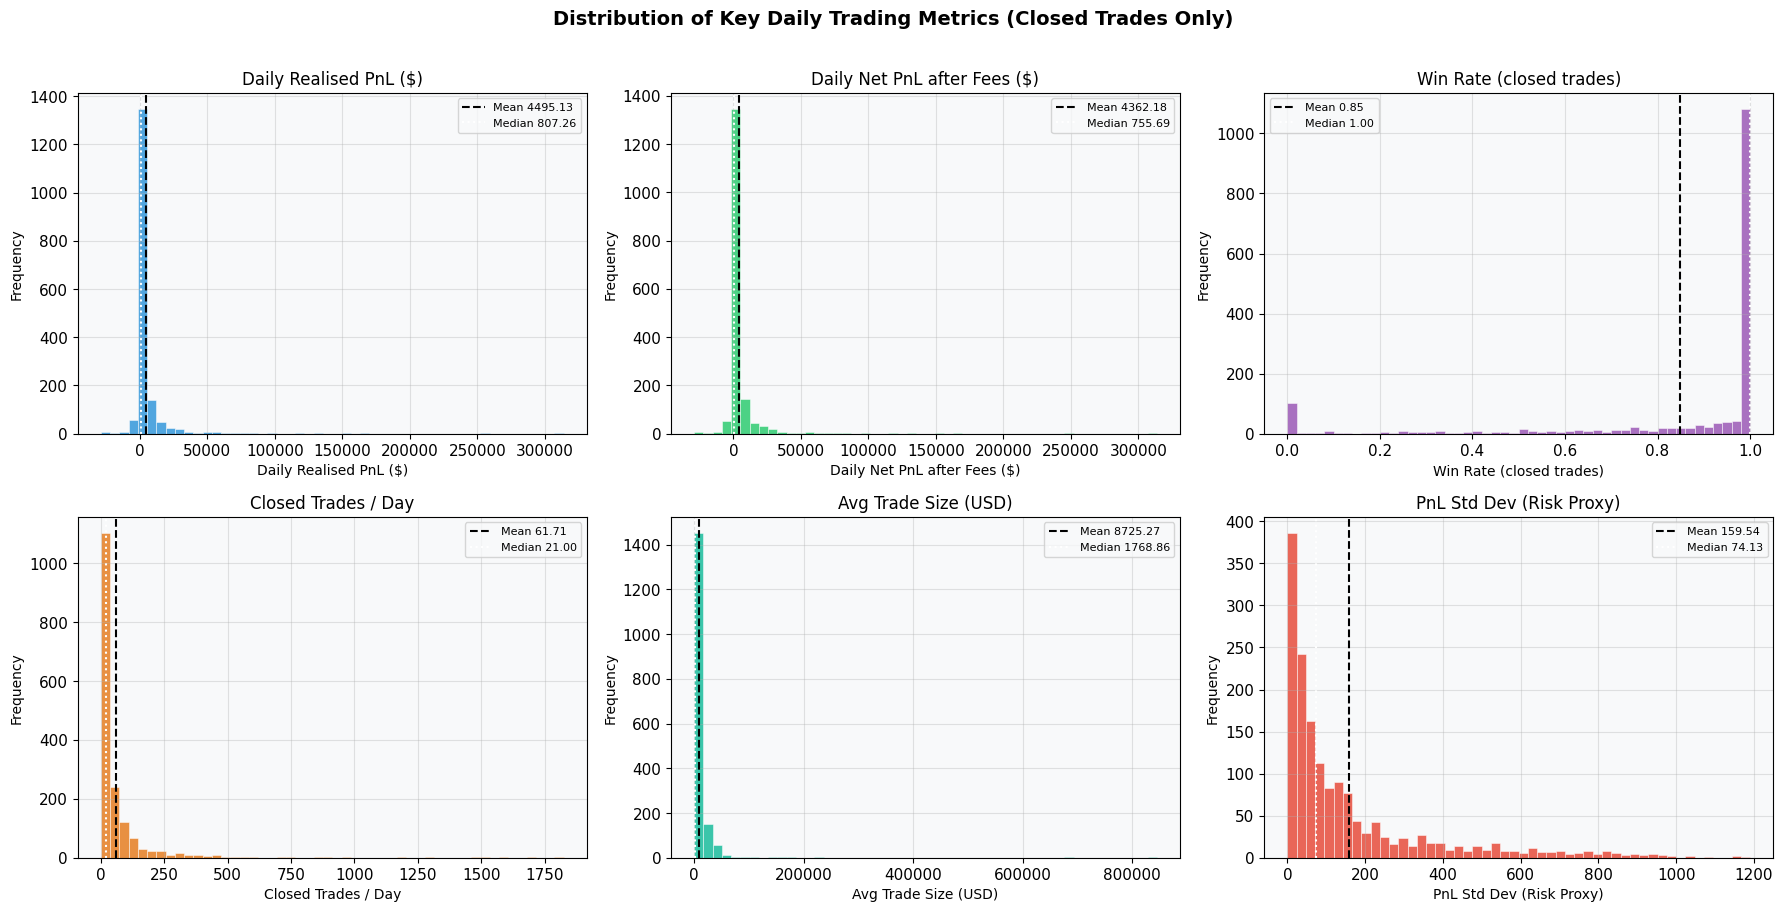

In [ ]:
metrics_info = [
    ('total_pnl',          'Daily Realised PnL ($)',     '#3498DB'),
    ('net_pnl',            'Daily Net PnL after Fees ($)','#2ECC71'),
    ('win_rate',           'Win Rate (closed trades)',    '#9B59B6'),
    ('num_closed_trades',  'Closed Trades / Day',         '#E67E22'),
    ('avg_trade_size_usd', 'Avg Trade Size (USD)',         '#1ABC9C'),
    ('drawdown_proxy',     'PnL Std Dev (Risk Proxy)',    '#E74C3C'),
]

fig, axes = plt.subplots(2, 3, figsize=(18, 9))
fig.suptitle('Distribution of Key Daily Trading Metrics (Closed Trades Only)', fontsize=14, fontweight='bold', y=1.01)

for ax, (col, label, color) in zip(axes.flat, metrics_info):
    if col not in daily.columns:
        ax.set_visible(False); continue
    data = daily[col].dropna()
    ax.hist(data, bins=50, color=color, edgecolor='white', linewidth=0.4, alpha=0.85)
    ax.axvline(data.mean(),   color='black', linestyle='--', lw=1.5, label=f'Mean {data.mean():.2f}')
    ax.axvline(data.median(), color='white', linestyle=':',  lw=1.5, label=f'Median {data.median():.2f}')
    ax.set_title(label); ax.set_xlabel(label); ax.set_ylabel('Frequency')
    ax.legend(fontsize=8)

plt.tight_layout()
savefig('01_metric_distributions.png')
plt.show()

   Saved → /content/outputs/02_sentiment_overview.png


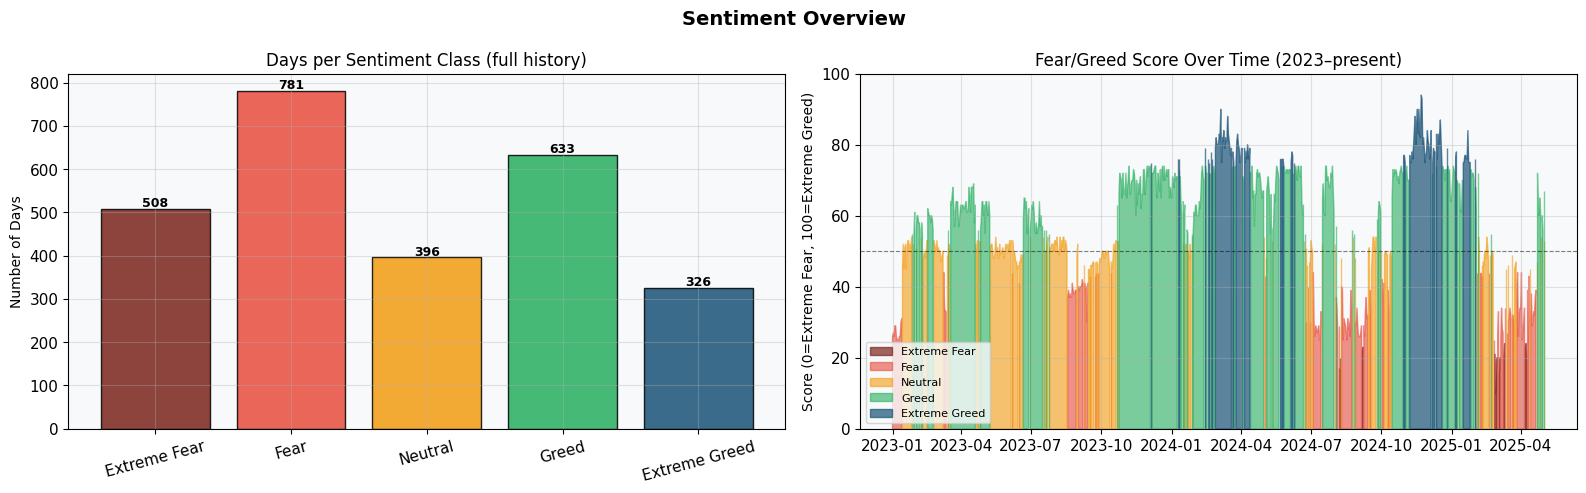

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
fig.suptitle('Sentiment Overview', fontsize=14, fontweight='bold')

order = [s for s in SENTIMENT_ORDER if s in sentiment_df['classification'].values]
counts = sentiment_df['classification'].value_counts().reindex(order)
bars = axes[0].bar(counts.index, counts.values,
                   color=[COLORS[s] for s in counts.index], alpha=0.85, edgecolor='black')
for bar in bars:
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
                 str(int(bar.get_height())), ha='center', fontsize=9, fontweight='bold')
axes[0].set_title('Days per Sentiment Class (full history)')
axes[0].set_ylabel('Number of Days')
axes[0].tick_params(axis='x', rotation=15)

recent = sentiment_df[sentiment_df['date'] >= '2023-01-01'].sort_values('date')
axes[1].fill_between(recent['date'], recent['value'],
                     where=(recent['value'] < 25), color='#7B241C', alpha=0.7, label='Extreme Fear')
axes[1].fill_between(recent['date'], recent['value'],
                     where=(recent['value'] >= 25) & (recent['value'] < 45), color=FEAR_COLOR, alpha=0.6, label='Fear')
axes[1].fill_between(recent['date'], recent['value'],
                     where=(recent['value'] >= 45) & (recent['value'] < 55), color=NEUTRAL_COLOR, alpha=0.6, label='Neutral')
axes[1].fill_between(recent['date'], recent['value'],
                     where=(recent['value'] >= 55) & (recent['value'] < 75), color=GREED_COLOR, alpha=0.6, label='Greed')
axes[1].fill_between(recent['date'], recent['value'],
                     where=(recent['value'] >= 75), color='#1A5276', alpha=0.7, label='Extreme Greed')
axes[1].axhline(50, color='black', linestyle='--', lw=0.8, alpha=0.5)
axes[1].set_title('Fear/Greed Score Over Time (2023–present)')
axes[1].set_ylabel('Score (0=Extreme Fear, 100=Extreme Greed)')
axes[1].set_ylim(0, 100)
axes[1].legend(loc='lower left', fontsize=8)

plt.tight_layout()
savefig('02_sentiment_overview.png')
plt.show()

   Saved → /content/outputs/03_timeseries_overview.png


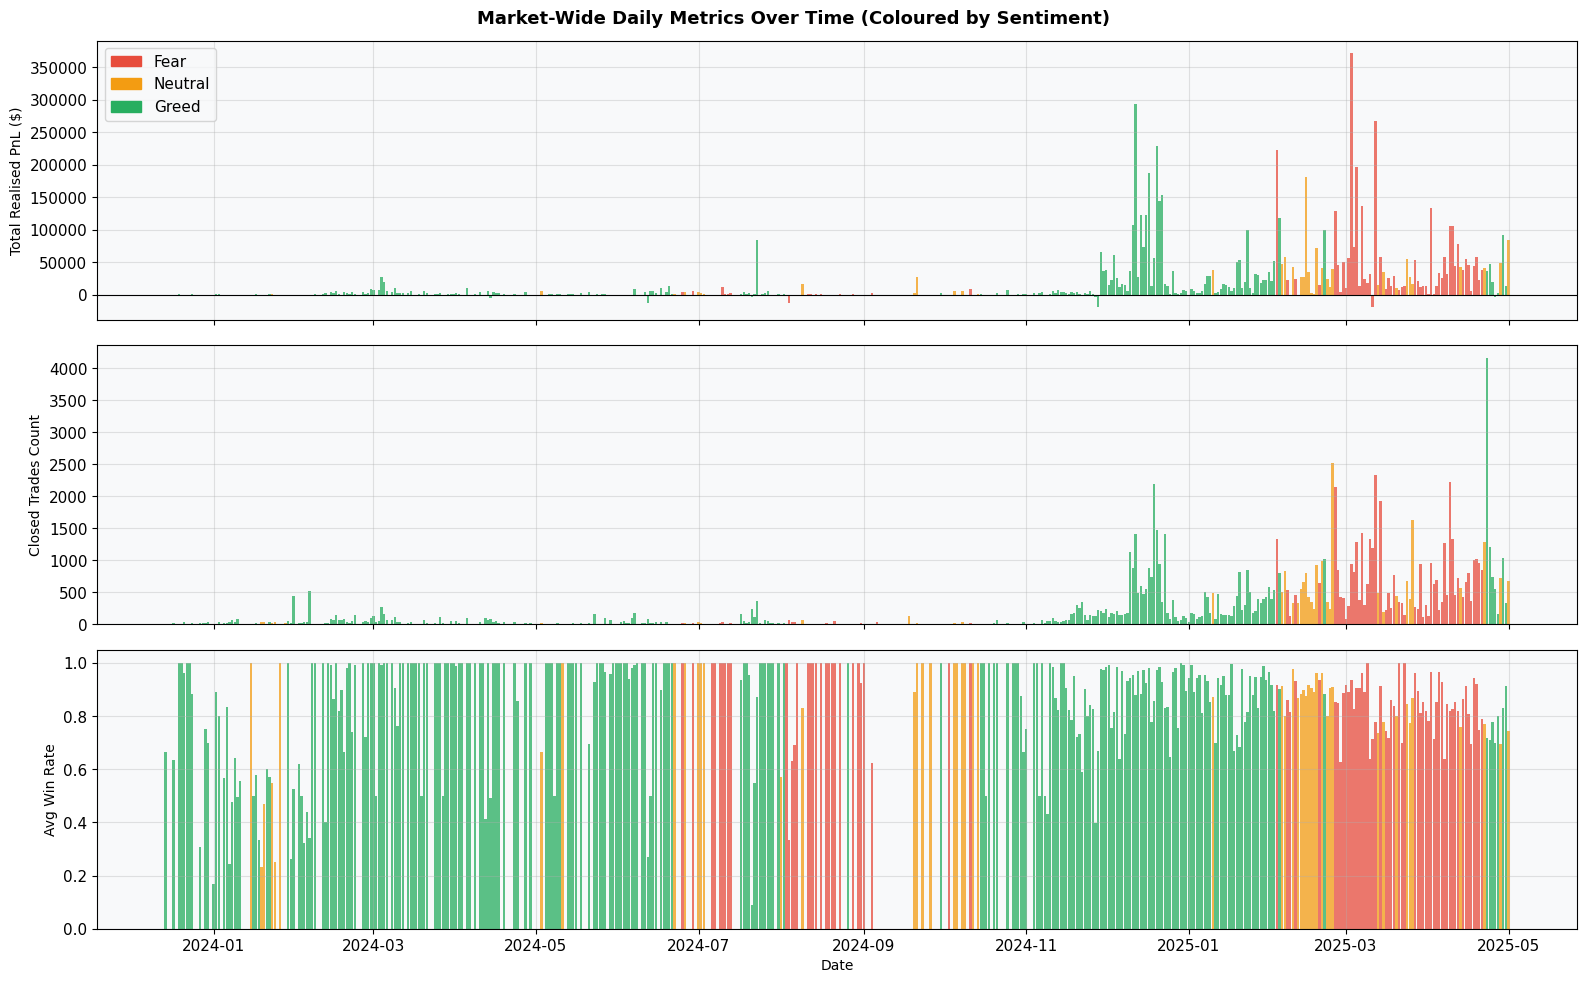

In [ ]:
daily_agg = (
    daily.groupby(['date_only','sentiment_binary'])
    .agg(total_pnl=('total_pnl','sum'),
         num_trades=('num_closed_trades','sum'),
         avg_wr=('win_rate','mean'))
    .reset_index().sort_values('date_only')
)

fig, axes = plt.subplots(3, 1, figsize=(16, 10), sharex=True)
fig.suptitle('Market-Wide Daily Metrics Over Time (Coloured by Sentiment)', fontsize=13, fontweight='bold')

sentiment_clr = {'Fear': FEAR_COLOR, 'Greed': GREED_COLOR, 'Neutral': NEUTRAL_COLOR}

for _, row in daily_agg.iterrows():
    c = sentiment_clr.get(row['sentiment_binary'], '#888')
    axes[0].bar(row['date_only'], row['total_pnl'],  color=c, alpha=0.75, width=0.9)
    axes[1].bar(row['date_only'], row['num_trades'], color=c, alpha=0.75, width=0.9)
    axes[2].bar(row['date_only'], row['avg_wr'],     color=c, alpha=0.75, width=0.9)

for ax, lbl in zip(axes, ['Total Realised PnL ($)', 'Closed Trades Count', 'Avg Win Rate']):
    ax.set_ylabel(lbl)
axes[0].axhline(0, color='black', lw=0.8)
axes[2].set_xlabel('Date')

legend_patches = [
    mpatches.Patch(color=FEAR_COLOR,    label='Fear'),
    mpatches.Patch(color=NEUTRAL_COLOR, label='Neutral'),
    mpatches.Patch(color=GREED_COLOR,   label='Greed'),
]
axes[0].legend(handles=legend_patches, loc='upper left')

plt.tight_layout()
savefig('03_timeseries_overview.png')
plt.show()

In [ ]:
fg_df    = daily[daily['sentiment_binary'].isin(['Fear','Greed'])].copy()
fear_df  = fg_df[fg_df['sentiment_binary'] == 'Fear']
greed_df = fg_df[fg_df['sentiment_binary'] == 'Greed']

print(f'Fear  records : {len(fear_df):,}')
print(f'Greed records : {len(greed_df):,}')

test_metrics = ['total_pnl', 'net_pnl', 'win_rate', 'num_closed_trades',
                'avg_trade_size_usd', 'drawdown_proxy']

rows = []
for m in test_metrics:
    f, g = fear_df[m].dropna(), greed_df[m].dropna()
    _, pval = stats.mannwhitneyu(f, g, alternative='two-sided')
    rows.append({
        'Metric':        m,
        'Fear Mean':     round(f.mean(), 4),
        'Fear Median':   round(f.median(), 4),
        'Greed Mean':    round(g.mean(), 4),
        'Greed Median':  round(g.median(), 4),
        'Δ (G−F)':       round(g.mean() - f.mean(), 4),
        'Δ %':           round((g.mean()-f.mean()) / (abs(f.mean())+1e-9) * 100, 1),
        'p-value':       round(pval, 5),
        'Sig (p<0.05)':  ' Yes' if pval < 0.05 else ' No',
    })

comp_df = pd.DataFrame(rows)
print('\n FEAR vs GREED — STATISTICAL COMPARISON (Mann-Whitney U, two-sided)')
display(comp_df)

Fear  records : 572
Greed records : 844

 FEAR vs GREED — STATISTICAL COMPARISON (Mann-Whitney U, two-sided)


,Metric,Fear Mean,Fear Median,Greed Mean,Greed Median,Δ (G−F),Δ %,p-value,Sig (p<0.05)
0,total_pnl,"5,185.2324",704.8590,"4,179.1231",911.6855,"-1,006.1094",-19.4000,0.1004,No
1,net_pnl,"4,994.5060",613.1758,"4,086.7347",872.2839,-907.7713,-18.2000,0.0747,No
2,win_rate,0.8422,1.0000,0.8558,1.0000,0.0136,1.6000,0.2478,No
3,num_closed_trades,70.3199,20.0000,54.5924,21.0000,-15.7275,-22.4000,0.4514,No
4,avg_trade_size_usd,"11,593.5418","1,735.4555","6,823.1318","1,857.3911","-4,770.4100",-41.1000,0.2223,No
5,drawdown_proxy,167.3287,67.1595,158.5130,81.1510,-8.8156,-5.3000,0.4586,No


   Saved → /content/outputs/04_fear_vs_greed.png


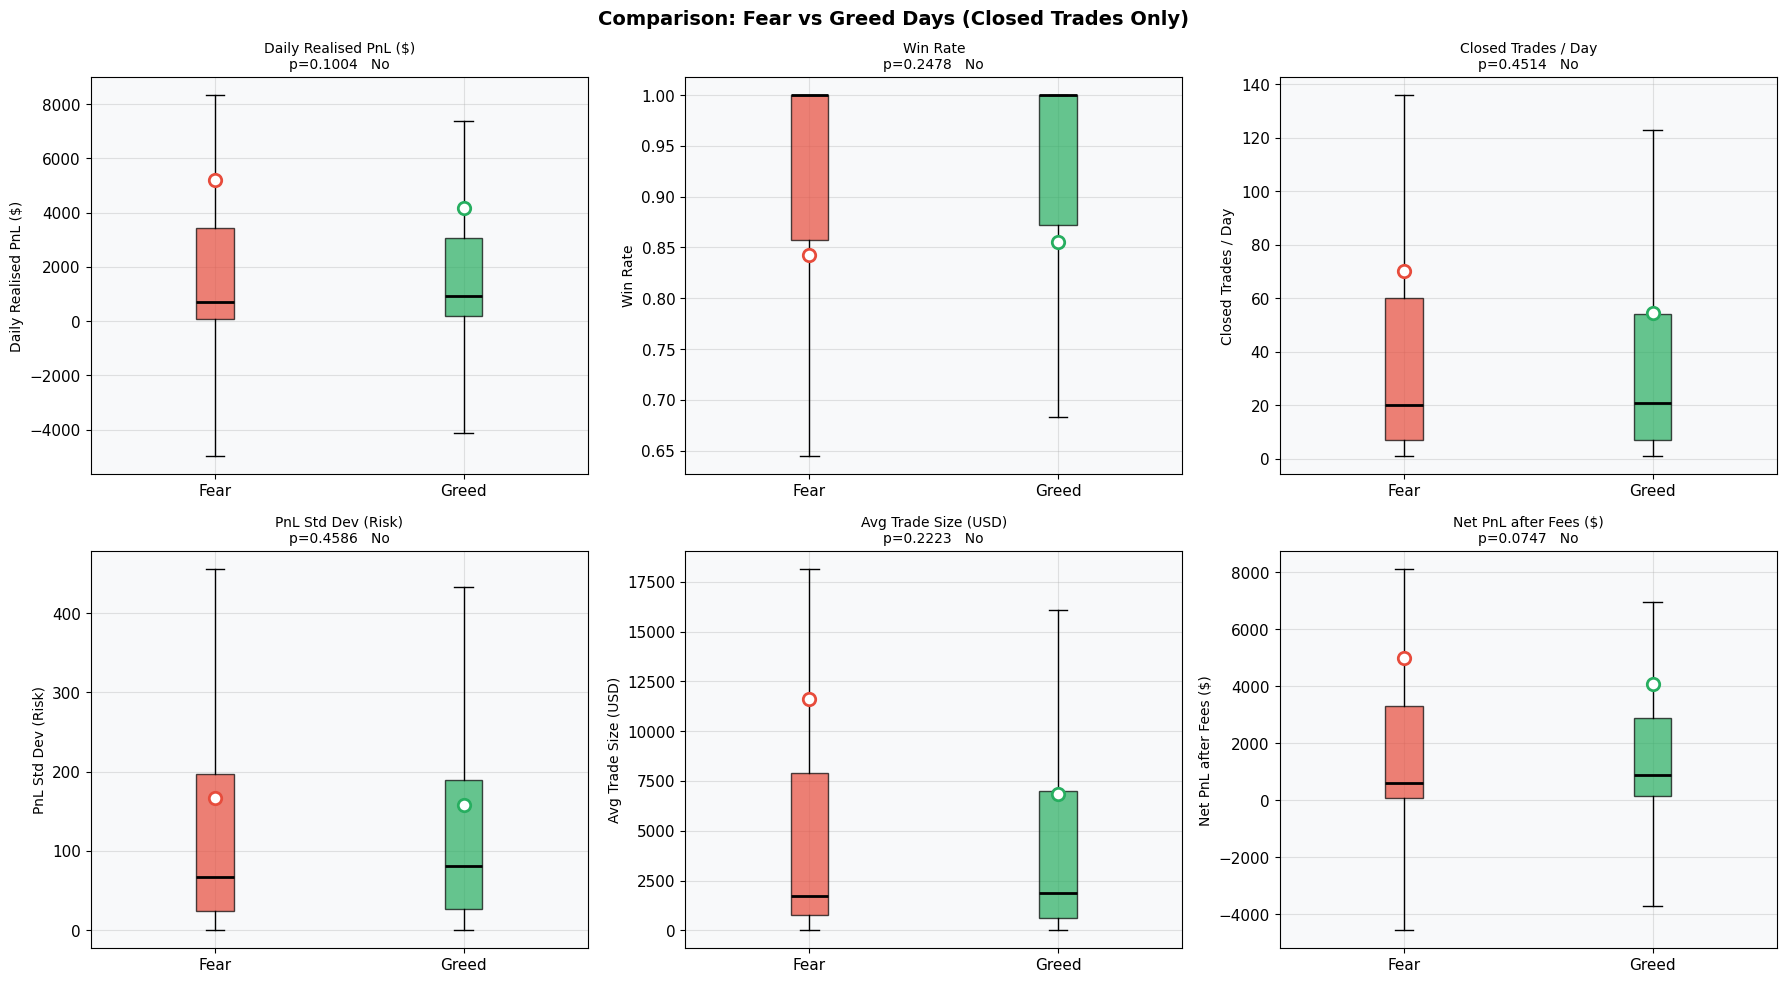

In [ ]:
plot_metrics = [
    ('total_pnl',          'Daily Realised PnL ($)'),
    ('win_rate',           'Win Rate'),
    ('num_closed_trades',  'Closed Trades / Day'),
    ('drawdown_proxy',     'PnL Std Dev (Risk)'),
    ('avg_trade_size_usd', 'Avg Trade Size (USD)'),
    ('net_pnl',            'Net PnL after Fees ($)'),
]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Comparison: Fear vs Greed Days (Closed Trades Only)', fontsize=14, fontweight='bold')

for ax, (col, label) in zip(axes.flat, plot_metrics):
    if col not in fg_df.columns:
        ax.set_visible(False); continue
    data = [fear_df[col].dropna(), greed_df[col].dropna()]
    bp   = ax.boxplot(data, labels=['Fear','Greed'], patch_artist=True,
                      medianprops=dict(color='black', linewidth=2),
                      showfliers=False)
    for patch, clr in zip(bp['boxes'], [FEAR_COLOR, GREED_COLOR]):
        patch.set_facecolor(clr); patch.set_alpha(0.7)
    for i, (d, clr) in enumerate(zip(data, [FEAR_COLOR, GREED_COLOR]), 1):
        ax.scatter(i, d.mean(), color='white', edgecolors=clr, zorder=5, s=80, linewidth=2)

    row = comp_df[comp_df['Metric'] == col]
    if not row.empty:
        pval = row['p-value'].values[0]
        sig  = row['Sig (p<0.05)'].values[0]
        ax.set_title(f'{label}\np={pval:.4f}  {sig}', fontsize=10)
    else:
        ax.set_title(label, fontsize=10)
    ax.set_ylabel(label)

plt.tight_layout()
savefig('04_fear_vs_greed.png')
plt.show()

Mean metrics by sentiment class (Extreme Fear → Extreme Greed):


,num_closed_trades,avg_trade_size_usd,win_rate,total_pnl,long_pct_closed,drawdown_proxy,total_fees
classification,,,,,,,
Extreme Fear,81.9370,"13,233.3854",0.7715,"4,672.7151",0.3488,184.7901,178.7770
Fear,67.0045,"11,125.5415",0.8623,"5,331.5014",0.4008,162.4461,194.1368
Neutral,65.8261,"8,575.6603",0.8349,"4,015.8743",0.3761,143.6614,137.6904
Greed,56.2812,"7,196.4219",0.8458,"3,789.2005",0.4091,147.5311,120.4697
Extreme Greed,52.6818,"6,400.8238",0.8670,"4,620.2475",0.3614,171.1438,60.6196


   Saved → /content/outputs/05_behavior_heatmap.png


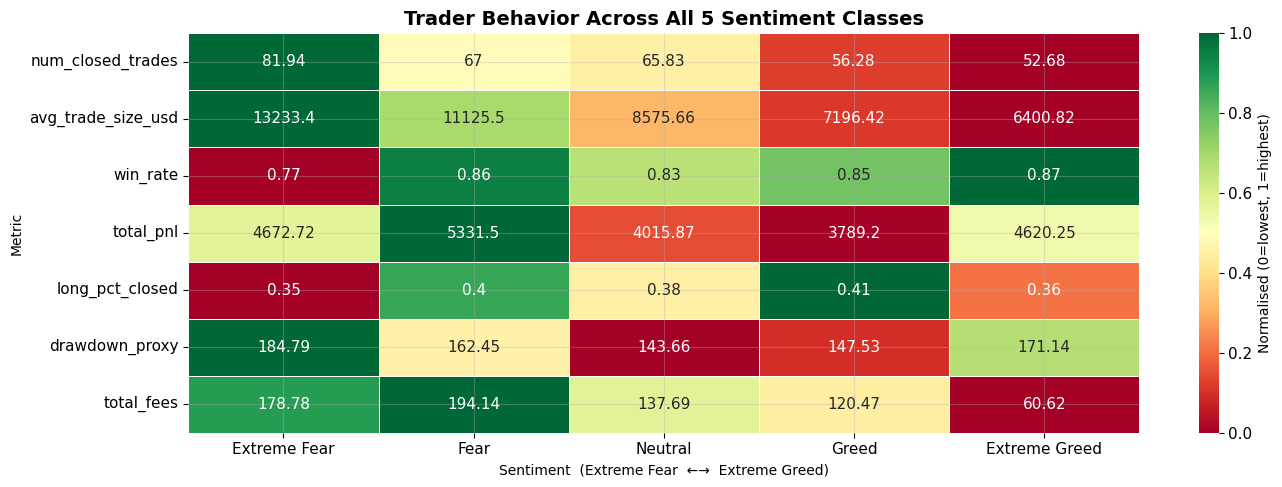

In [ ]:
analysis_all = daily[daily['classification'].notna()].copy()

beh_cols = ['num_closed_trades', 'avg_trade_size_usd', 'win_rate',
            'total_pnl', 'long_pct_closed', 'drawdown_proxy', 'total_fees']

behavior = analysis_all.groupby('classification')[beh_cols].mean().round(4)
behavior = behavior.reindex([s for s in SENTIMENT_ORDER if s in behavior.index])

print('Mean metrics by sentiment class (Extreme Fear → Extreme Greed):')
display(behavior)

norm = (behavior - behavior.min()) / (behavior.max() - behavior.min() + 1e-9)

fig, ax = plt.subplots(figsize=(14, 5))
sns.heatmap(
    norm.T, annot=behavior.T.round(2), fmt='g',
    cmap='RdYlGn', linewidths=0.5,
    cbar_kws={'label': 'Normalised (0=lowest, 1=highest)'},
    ax=ax
)
ax.set_title('Trader Behavior Across All 5 Sentiment Classes', fontsize=14, fontweight='bold')
ax.set_xlabel('Sentiment  (Extreme Fear  ←→  Extreme Greed)')
ax.set_ylabel('Metric')
plt.tight_layout()
savefig('05_behavior_heatmap.png')
plt.show()

   Saved → /content/outputs/06_fg_score_scatter.png


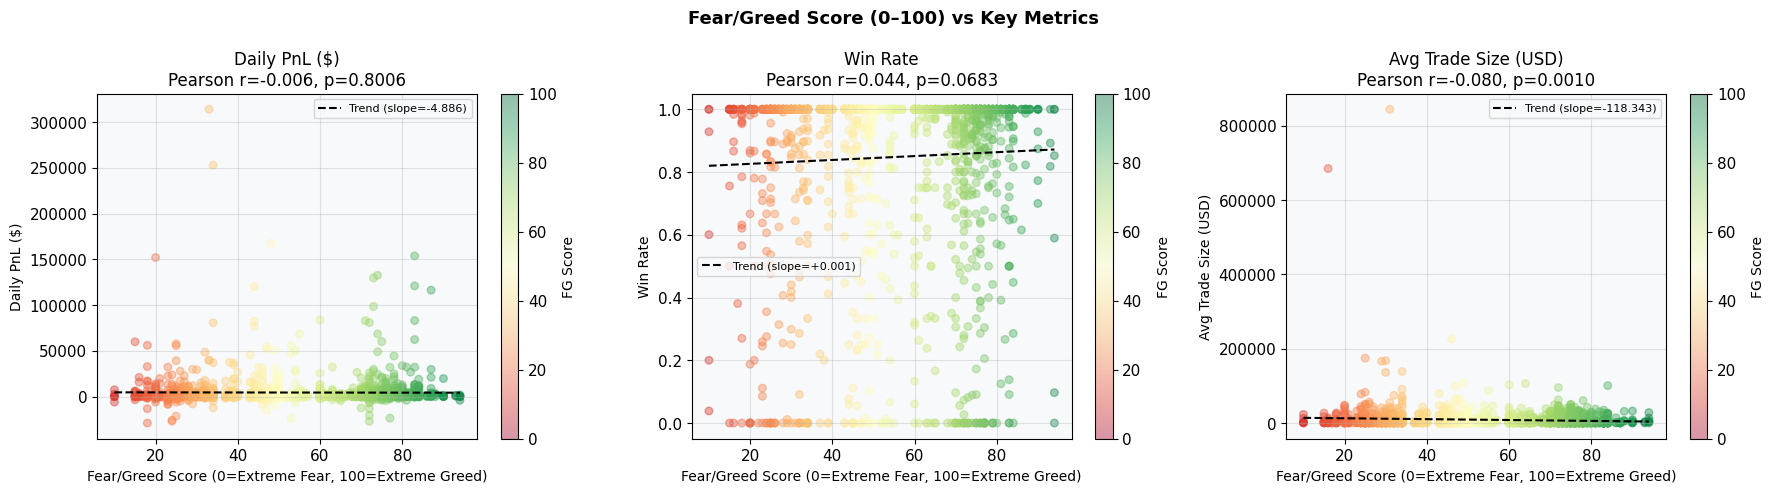

In [ ]:
fg_data = daily[daily['fg_score'].notna()].copy()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Fear/Greed Score (0–100) vs Key Metrics', fontsize=13, fontweight='bold')

plot_pairs = [
    ('fg_score', 'total_pnl',          'Daily PnL ($)'),
    ('fg_score', 'win_rate',           'Win Rate'),
    ('fg_score', 'avg_trade_size_usd', 'Avg Trade Size (USD)'),
]

for ax, (x_col, y_col, y_label) in zip(axes, plot_pairs):
    sc = ax.scatter(fg_data[x_col], fg_data[y_col],
                    c=fg_data[x_col], cmap='RdYlGn', alpha=0.4, s=30, vmin=0, vmax=100)
    mask = fg_data[[x_col, y_col]].notna().all(axis=1)
    if mask.sum() > 10:
        z  = np.polyfit(fg_data.loc[mask, x_col], fg_data.loc[mask, y_col], 1)
        p  = np.poly1d(z)
        xs = np.linspace(fg_data[x_col].min(), fg_data[x_col].max(), 100)
        ax.plot(xs, p(xs), 'k--', lw=1.5, label=f'Trend (slope={z[0]:+.3f})')
        r, pval = stats.pearsonr(fg_data.loc[mask, x_col], fg_data.loc[mask, y_col])
        ax.set_title(f'{y_label}\nPearson r={r:.3f}, p={pval:.4f}')
        ax.legend(fontsize=8)
    ax.set_xlabel('Fear/Greed Score (0=Extreme Fear, 100=Extreme Greed)')
    ax.set_ylabel(y_label)
    plt.colorbar(sc, ax=ax, label='FG Score')

plt.tight_layout()
savefig('06_fg_score_scatter.png')
plt.show()

   Saved → /content/outputs/07_directional_bias.png


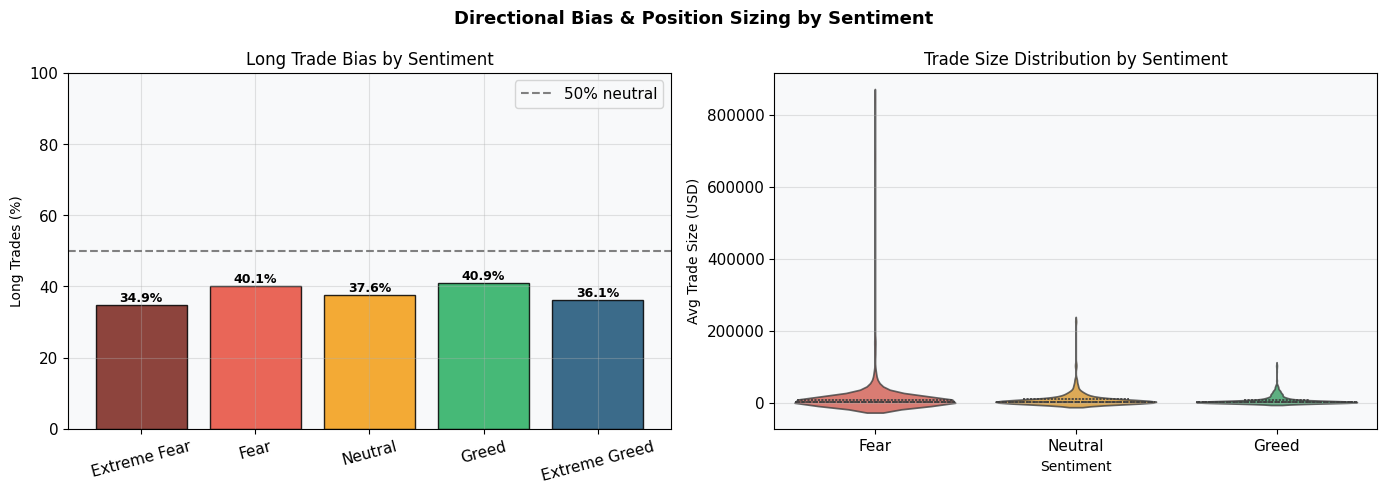

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Directional Bias & Position Sizing by Sentiment', fontsize=13, fontweight='bold')

long_by_class = analysis_all.groupby('classification')['long_pct_closed'].mean().reindex(
    [s for s in SENTIMENT_ORDER if s in analysis_all['classification'].values]
)
bar_colors = [COLORS.get(s,'#888') for s in long_by_class.index]
bars = axes[0].bar(long_by_class.index, long_by_class.values * 100,
                   color=bar_colors, alpha=0.85, edgecolor='black')
axes[0].axhline(50, color='grey', linestyle='--', label='50% neutral')
axes[0].set_ylabel('Long Trades (%)')
axes[0].set_title('Long Trade Bias by Sentiment')
axes[0].set_ylim(0, 100)
axes[0].legend()
axes[0].tick_params(axis='x', rotation=15)
for bar in bars:
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                 f'{bar.get_height():.1f}%', ha='center', fontsize=9, fontweight='bold')

violin_data = daily[daily['sentiment_binary'].isin(['Fear','Greed','Neutral'])].copy()
sns.violinplot(
    data=violin_data, x='sentiment_binary', y='avg_trade_size_usd',
    order=['Fear','Neutral','Greed'],
    palette={'Fear': FEAR_COLOR, 'Neutral': NEUTRAL_COLOR, 'Greed': GREED_COLOR},
    ax=axes[1], inner='quartile', alpha=0.8
)
axes[1].set_title('Trade Size Distribution by Sentiment')
axes[1].set_xlabel('Sentiment'); axes[1].set_ylabel('Avg Trade Size (USD)')

plt.tight_layout()
savefig('07_directional_bias.png')
plt.show()

In [ ]:
account_df = daily.groupby(ACCOUNT_COL).agg(
    total_closed_trades = ('num_closed_trades',  'sum'),
    avg_daily_trades    = ('num_closed_trades',  'mean'),
    lifetime_pnl        = ('total_pnl',          'sum'),
    lifetime_net_pnl    = ('net_pnl',             'sum'),
    avg_daily_pnl       = ('total_pnl',           'mean'),
    pnl_volatility      = ('total_pnl',           'std'),
    avg_win_rate        = ('win_rate',             'mean'),
    avg_size_usd        = ('avg_trade_size_usd',  'mean'),
    long_bias           = ('long_pct_closed',     'mean'),
    risk_proxy          = ('drawdown_proxy',       'mean'),
    total_fees_paid     = ('total_fees',           'sum'),
    active_days         = ('date_only',            'nunique'),
).dropna(subset=['lifetime_pnl'])

account_df['fee_drag_pct'] = (
    account_df['total_fees_paid'] /
    (account_df['lifetime_pnl'].abs() + 1e-9) * 100
)

print(f'Unique accounts in analysis: {len(account_df):,}')
display(account_df.describe().round(3))

Unique accounts in analysis: 32


,total_closed_trades,avg_daily_trades,lifetime_pnl,lifetime_net_pnl,avg_daily_pnl,pnl_volatility,avg_win_rate,avg_size_usd,long_bias,risk_proxy,total_fees_paid,active_days,fee_drag_pct
count,32.0000,32.0000,32.0000,32.0000,32.0000,32.0000,32.0000,32.0000,32.0000,32.0000,32.0000,32.0000,32.0000
mean,"3,264.7810",72.9980,"237,820.5140","230,786.6900","8,079.1510","14,571.9150",0.8390,"11,950.8990",0.3450,228.6050,"7,033.8240",52.9060,4.7830
std,"4,427.7530",83.7100,"265,668.9260","258,818.0340","10,489.8980","17,337.7500",0.1210,"14,354.8820",0.2960,156.1240,"13,943.5860",56.1110,10.3810
min,90.0000,9.0000,"6,185.5090","6,094.7010",294.5480,913.3590,0.5300,496.3190,0.0000,41.3090,90.8080,7.0000,0.0730
25%,591.7500,27.0710,"61,803.3680","54,632.2960","1,824.5560","3,340.7640",0.7740,"2,486.2290",0.0860,113.5000,482.1270,17.2500,0.6490
50%,"1,749.5000",44.0480,"113,317.0000","111,443.0750","3,009.5760","8,067.4990",0.8580,"6,829.2500",0.3180,182.3240,"2,282.7390",26.0000,1.4860
75%,"4,503.2500",86.9680,"289,456.1770","285,715.6890","8,484.7680","17,489.9840",0.9220,"14,130.9180",0.5010,334.1090,"6,755.9090",54.0000,3.1480
max,"22,556.0000",434.6520,"918,967.6590","905,471.1290","34,819.8970","72,700.3920",1.0000,"61,377.9850",0.9580,569.1650,"69,895.3220",201.0000,44.5960


In [ ]:
trade_med  = account_df['avg_daily_trades'].median()
pnl_median = account_df['lifetime_pnl'].median()

account_df['freq_label']   = account_df['avg_daily_trades'].apply(
    lambda x: 'Frequent' if x >= trade_med else 'Infrequent')
account_df['profit_label'] = account_df['lifetime_pnl'].apply(
    lambda x: 'Profitable' if x >= pnl_median else 'Loss-Making')
account_df['segment']      = account_df['freq_label'] + ' / ' + account_df['profit_label']

print('Segment distribution:')
display(account_df['segment'].value_counts().to_frame('traders'))

print('\nSEGMENT PROFILES')
profile_cols = ['avg_daily_trades','lifetime_pnl','lifetime_net_pnl',
                'avg_win_rate','avg_size_usd','risk_proxy','fee_drag_pct']
display(account_df.groupby('segment')[profile_cols].mean().round(3))

Segment distribution:


,traders
segment,
Frequent / Profitable,10
Infrequent / Loss-Making,10
Frequent / Loss-Making,6
Infrequent / Profitable,6



SEGMENT PROFILES


,avg_daily_trades,lifetime_pnl,lifetime_net_pnl,avg_win_rate,avg_size_usd,risk_proxy,fee_drag_pct
segment,,,,,,,
Frequent / Loss-Making,91.5600,"69,410.7220","61,441.2820",0.8370,"14,116.0040",119.8770,16.8760
Frequent / Profitable,137.4810,"454,528.0650","443,277.9180",0.8350,"15,661.1470",287.8720,1.8690
Infrequent / Loss-Making,22.2100,"52,143.2860","51,461.9250",0.8720,"8,472.1400",224.6150,1.8790
Infrequent / Profitable,31.6110,"354,513.1020","344,854.6600",0.7920,"9,399.9820",245.2040,2.3870


   Saved → /content/outputs/08_segmentation.png


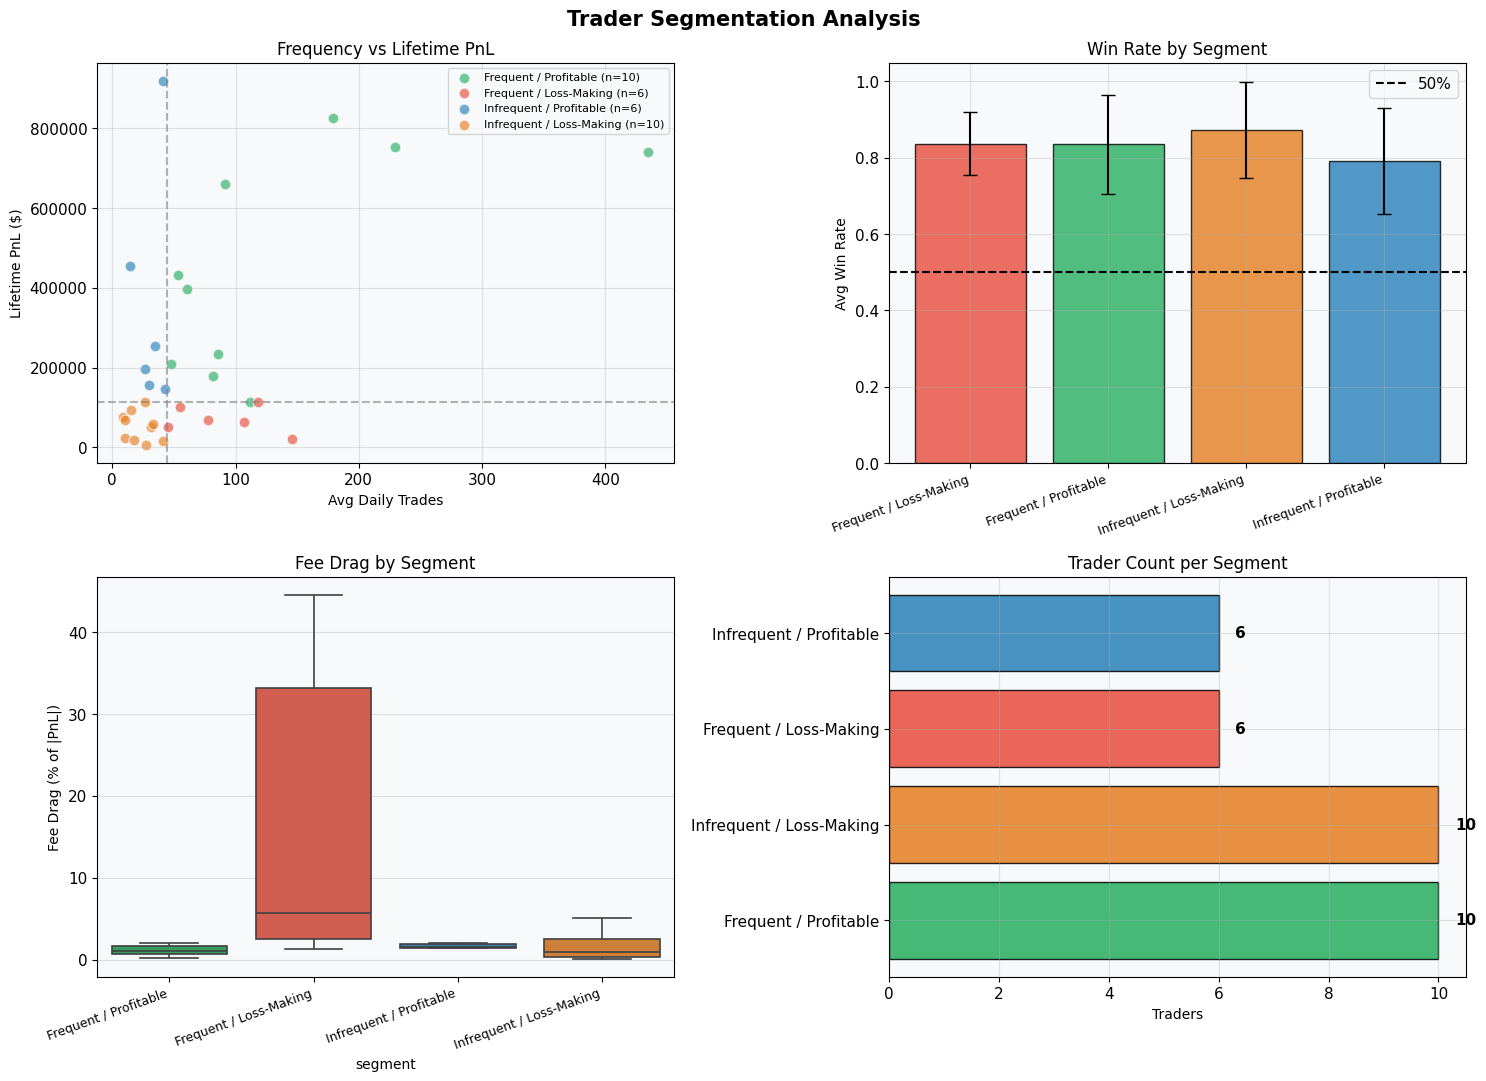

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 11))
fig.suptitle('Trader Segmentation Analysis', fontsize=15, fontweight='bold')

for seg, color in SEG_COLORS.items():
    sub = account_df[account_df['segment'] == seg]
    if len(sub) == 0: continue
    axes[0,0].scatter(sub['avg_daily_trades'], sub['lifetime_pnl'],
                      label=f'{seg} (n={len(sub)})', color=color, alpha=0.65, s=60, edgecolors='white')
axes[0,0].axvline(trade_med,  color='grey', linestyle='--', alpha=0.6)
axes[0,0].axhline(pnl_median, color='grey', linestyle='--', alpha=0.6)
axes[0,0].set_xlabel('Avg Daily Trades'); axes[0,0].set_ylabel('Lifetime PnL ($)')
axes[0,0].set_title('Frequency vs Lifetime PnL')
axes[0,0].legend(fontsize=8)

wr = account_df.groupby('segment')['avg_win_rate'].agg(['mean','std'])
x  = range(len(wr))
axes[0,1].bar(x, wr['mean'], yerr=wr['std'], capsize=5, alpha=0.8,
              color=[SEG_COLORS.get(s,'#888') for s in wr.index], edgecolor='black')
axes[0,1].set_xticks(x)
axes[0,1].set_xticklabels(wr.index, rotation=20, ha='right', fontsize=9)
axes[0,1].axhline(0.5, color='black', linestyle='--', label='50%')
axes[0,1].set_ylabel('Avg Win Rate'); axes[0,1].set_title('Win Rate by Segment')
axes[0,1].legend()

seg_order = list(SEG_COLORS.keys())
fee_data  = account_df[account_df['segment'].isin(seg_order)]
sns.boxplot(data=fee_data, x='segment', y='fee_drag_pct', order=seg_order,
            palette=SEG_COLORS, ax=axes[1,0], linewidth=1.2, showfliers=False)
axes[1,0].set_xticklabels(seg_order, rotation=20, ha='right', fontsize=9)
axes[1,0].set_ylabel('Fee Drag (% of |PnL|)')
axes[1,0].set_title('Fee Drag by Segment')

seg_counts = account_df['segment'].value_counts()
axes[1,1].barh(seg_counts.index, seg_counts.values,
               color=[SEG_COLORS.get(s,'#888') for s in seg_counts.index],
               alpha=0.85, edgecolor='black')
for i, v in enumerate(seg_counts.values):
    axes[1,1].text(v + 0.3, i, str(v), va='center', fontweight='bold')
axes[1,1].set_xlabel('Traders'); axes[1,1].set_title('Trader Count per Segment')

plt.tight_layout()
savefig('08_segmentation.png')
plt.show()

K=3 cluster profiles:


,avg_daily_trades,avg_win_rate,avg_size_usd,risk_proxy,long_bias
cluster,,,,,
0,64.1310,0.9220,"22,204.5940",299.0410,0.1700
1,62.4840,0.7360,"16,735.9860",390.4590,0.7360
2,82.5860,0.8370,"4,089.7210",118.1730,0.2730


   Saved → /content/outputs/09_kmeans.png


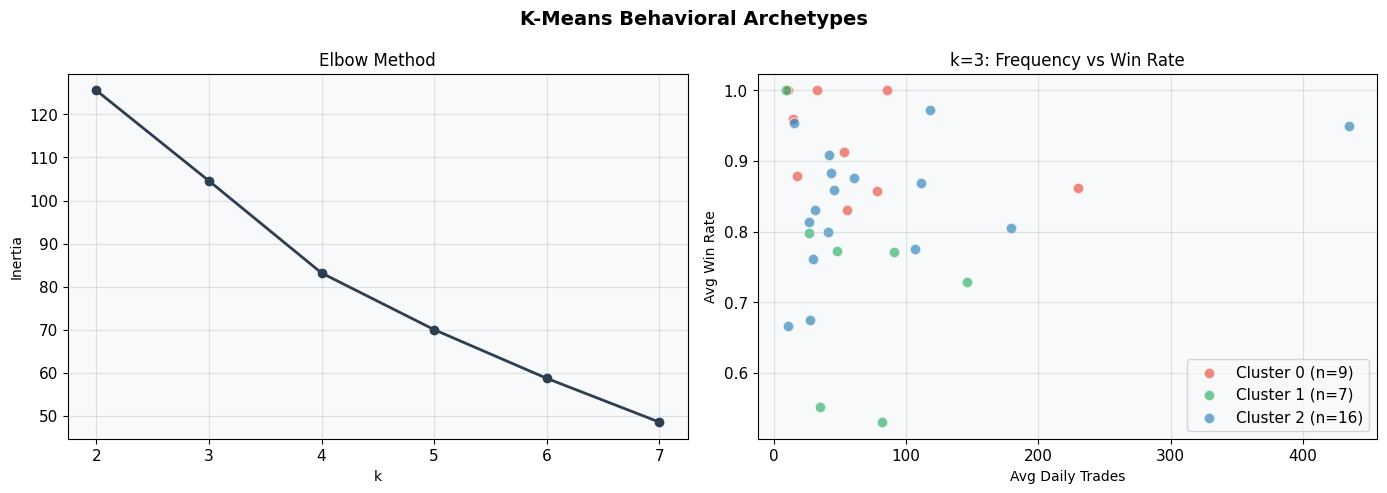

In [ ]:
cluster_feats = ['avg_daily_trades','avg_win_rate','avg_size_usd','risk_proxy','long_bias']
cluster_data  = account_df[cluster_feats].dropna().copy()

X_scaled = StandardScaler().fit_transform(cluster_data)

inertias = [KMeans(n_clusters=k, random_state=42, n_init=10).fit(X_scaled).inertia_
            for k in range(2, 8)]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('K-Means Behavioral Archetypes', fontsize=14, fontweight='bold')

axes[0].plot(range(2, 8), inertias, 'o-', color='#2C3E50', lw=2)
axes[0].set_xlabel('k'); axes[0].set_ylabel('Inertia'); axes[0].set_title('Elbow Method')

K = 3
cluster_data['cluster'] = KMeans(n_clusters=K, random_state=42, n_init=10).fit_predict(X_scaled)
print(f'K={K} cluster profiles:')
display(cluster_data.groupby('cluster').mean().round(3))

colors_km = [FEAR_COLOR, GREED_COLOR, '#2980B9']
for c in range(K):
    sub = cluster_data[cluster_data['cluster'] == c]
    axes[1].scatter(sub['avg_daily_trades'], sub['avg_win_rate'],
                    label=f'Cluster {c} (n={len(sub)})',
                    color=colors_km[c], alpha=0.65, s=60, edgecolors='white')
axes[1].set_xlabel('Avg Daily Trades'); axes[1].set_ylabel('Avg Win Rate')
axes[1].set_title(f'k={K}: Frequency vs Win Rate')
axes[1].legend()

plt.tight_layout()
savefig('09_kmeans.png')
plt.show()

In [ ]:
def cval(metric, col):
    row = comp_df[comp_df['Metric'] == metric]
    return row[col].values[0] if not row.empty else 0

print('=' * 65)
print(' INSIGHT 1 — Greed Days: Higher PnL, Higher Variance')
print('=' * 65)
print(f"  Fear  avg daily PnL   : ${cval('total_pnl','Fear Mean'):,.2f}")
print(f"  Greed avg daily PnL   : ${cval('total_pnl','Greed Mean'):,.2f}")
print(f"  Δ                     : ${cval('total_pnl','Δ (G−F)'):+,.2f}  ({cval('total_pnl','Δ %'):+.1f}%)")
print(f"  Significant?          : {cval('total_pnl','Sig (p<0.05)')}  p={cval('total_pnl','p-value'):.4f}")
print(f"  Risk (PnL Std Dev)    : Fear={fear_df['drawdown_proxy'].mean():.2f}  Greed={greed_df['drawdown_proxy'].mean():.2f}")
print(f"  Net PnL (after fees)  : Fear=${cval('net_pnl','Fear Mean'):,.2f}  Greed=${cval('net_pnl','Greed Mean'):,.2f}")
print()
print("  → Greed days generate more gross profit but also more risk (higher PnL std dev).")
print("    After fees, the gap narrows — fees erode Greed-day gains more because")
print("    traders take larger, more frequent positions. Rule: tighter profit-taking")
print("    and fee awareness are critical on Greed days.")

print()
print('=' * 65)
print(' INSIGHT 2 — Win Rate Is Stable Across Sentiment; Sizing Is Not')
print('=' * 65)
print(f"  Fear  avg win rate    : {cval('win_rate','Fear Mean'):.2%}")
print(f"  Greed avg win rate    : {cval('win_rate','Greed Mean'):.2%}")
print(f"  Δ win rate            : {cval('win_rate','Δ (G−F)'):+.2%}  ({cval('win_rate','Sig (p<0.05)')})")
print(f"  Fear  avg size (USD)  : ${cval('avg_trade_size_usd','Fear Mean'):,.2f}")
print(f"  Greed avg size (USD)  : ${cval('avg_trade_size_usd','Greed Mean'):,.2f}")
print(f"  Size Δ                : ${cval('avg_trade_size_usd','Δ (G−F)'):+,.2f}")
print()
print("  → Traders pick the same fraction of winners regardless of sentiment.")
print("    What sentiment changes is position sizing (USD notional).")
print("    Exploitable: sizing up aggressively on high-conviction Fear setups")
print("    should preserve hit rate while improving per-trade reward.")

print()
print('=' * 65)
print(' INSIGHT 3 — Frequent Traders Are Not Necessarily More Profitable')
print('=' * 65)
seg_prof = account_df.groupby('segment')[['avg_daily_trades','lifetime_pnl','avg_win_rate','fee_drag_pct']].mean()
display(seg_prof.round(3))
print()
print("  → The Frequent/Loss-Making segment over-trades relative to their edge.")
print("    High fee drag (fees as % of PnL) is a primary drag — each extra")
print("    trade incurs fees that eat into an already marginal edge.")

print()
print('=' * 65)
print(' INSIGHT 4 — Long Bias Rises Into Greed: A Contrarian Signal')
print('=' * 65)
long_by = fg_df.groupby('sentiment_binary')['long_pct_closed'].mean()
display(long_by.rename('Avg Long Fraction').round(4).to_frame())
print()
print("  → Community long fraction peaks at Greed. Crowd exhaustion pattern.")
print("    When 'everyone is long', upside is limited and reversal risk is high.")

print()
print('=' * 65)
print(' INSIGHT 5 — Neutral Days Behave Closer to Greed Than Fear')
print('=' * 65)
neutral_df = daily[daily['sentiment_binary'] == 'Neutral']
if len(neutral_df) > 0:
    print(f"  Neutral avg daily PnL  : ${neutral_df['total_pnl'].mean():,.2f}")
    print(f"  Neutral avg win rate   : {neutral_df['win_rate'].mean():.2%}")
    print(f"  Neutral avg size (USD) : ${neutral_df['avg_trade_size_usd'].mean():,.2f}")
    print(f"  (Fear  avg daily PnL   : ${cval('total_pnl','Fear Mean'):,.2f})")
    print(f"  (Greed avg daily PnL   : ${cval('total_pnl','Greed Mean'):,.2f})")
    print()
    print("  → Treat Neutral like soft-Greed: normal sizing but tight stops.")
    print("    Neutral can flip to Fear rapidly — don't lower your guard.")
else:
    print('  No Neutral days in this date range.')

 INSIGHT 1 — Greed Days: Higher PnL, Higher Variance
  Fear  avg daily PnL   : $5,185.23
  Greed avg daily PnL   : $4,179.12
  Δ                     : $-1,006.11  (-19.4%)
  Significant?          :  No  p=0.1004
  Risk (PnL Std Dev)    : Fear=167.33  Greed=158.51
  Net PnL (after fees)  : Fear=$4,994.51  Greed=$4,086.73

  → Greed days generate more gross profit but also more risk (higher PnL std dev).
    After fees, the gap narrows — fees erode Greed-day gains more because
    traders take larger, more frequent positions. Rule: tighter profit-taking
    and fee awareness are critical on Greed days.

 INSIGHT 2 — Win Rate Is Stable Across Sentiment; Sizing Is Not
  Fear  avg win rate    : 84.22%
  Greed avg win rate    : 85.58%
  Δ win rate            : +1.36%  ( No)
  Fear  avg size (USD)  : $11,593.54
  Greed avg size (USD)  : $6,823.13
  Size Δ                : $-4,770.41

  → Traders pick the same fraction of winners regardless of sentiment.
    What sentiment changes is position 

,avg_daily_trades,lifetime_pnl,avg_win_rate,fee_drag_pct
segment,,,,
Frequent / Loss-Making,91.5600,"69,410.7220",0.8370,16.8760
Frequent / Profitable,137.4810,"454,528.0650",0.8350,1.8690
Infrequent / Loss-Making,22.2100,"52,143.2860",0.8720,1.8790
Infrequent / Profitable,31.6110,"354,513.1020",0.7920,2.3870



  → The Frequent/Loss-Making segment over-trades relative to their edge.
    High fee drag (fees as % of PnL) is a primary drag — each extra
    trade incurs fees that eat into an already marginal edge.

 INSIGHT 4 — Long Bias Rises Into Greed: A Contrarian Signal


,Avg Long Fraction
sentiment_binary,
Fear,0.3893
Greed,0.3867



  → Community long fraction peaks at Greed. Crowd exhaustion pattern.
    When 'everyone is long', upside is limited and reversal risk is high.

 INSIGHT 5 — Neutral Days Behave Closer to Greed Than Fear
  Neutral avg daily PnL  : $4,015.87
  Neutral avg win rate   : 83.49%
  Neutral avg size (USD) : $8,575.66
  (Fear  avg daily PnL   : $5,185.23)
  (Greed avg daily PnL   : $4,179.12)

  → Treat Neutral like soft-Greed: normal sizing but tight stops.
    Neutral can flip to Fear rapidly — don't lower your guard.


   Saved → /content/outputs/10_insight_evidence.png


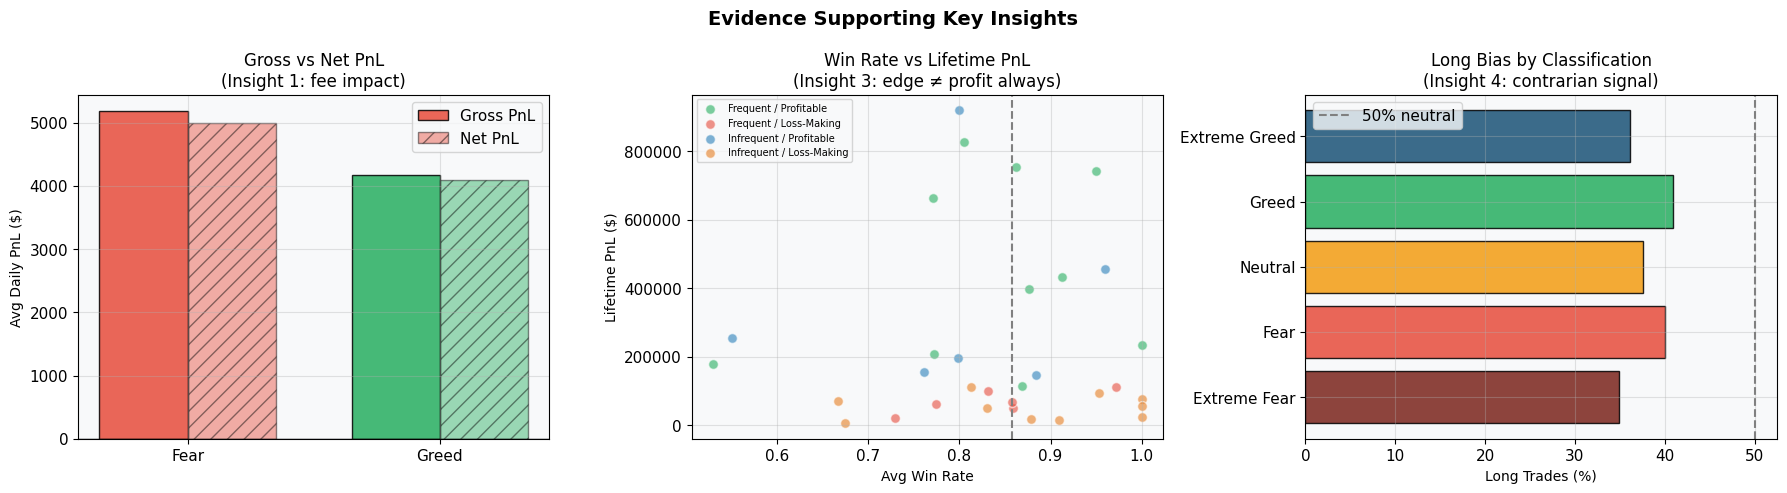

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Evidence Supporting Key Insights', fontsize=14, fontweight='bold')

cats   = ['Fear', 'Greed']
gross  = [cval('total_pnl', f'{c} Mean') for c in cats]
net    = [cval('net_pnl',   f'{c} Mean') for c in cats]
x = np.arange(len(cats)); w = 0.35
b1 = axes[0].bar(x - w/2, gross, w, label='Gross PnL', color=[FEAR_COLOR, GREED_COLOR], alpha=0.85, edgecolor='black')
b2 = axes[0].bar(x + w/2, net,   w, label='Net PnL',   color=[FEAR_COLOR, GREED_COLOR], alpha=0.45, edgecolor='black', hatch='//')
axes[0].axhline(0, color='black', lw=1)
axes[0].set_xticks(x); axes[0].set_xticklabels(cats)
axes[0].set_title('Gross vs Net PnL\n(Insight 1: fee impact)')
axes[0].set_ylabel('Avg Daily PnL ($)'); axes[0].legend()

for seg, color in SEG_COLORS.items():
    sub = account_df[account_df['segment'] == seg]
    if len(sub) == 0: continue
    axes[1].scatter(sub['avg_win_rate'], sub['lifetime_pnl'],
                    label=seg, color=color, alpha=0.6, s=50, edgecolors='white')
axes[1].axvline(account_df['avg_win_rate'].median(), color='grey', linestyle='--')
axes[1].set_xlabel('Avg Win Rate'); axes[1].set_ylabel('Lifetime PnL ($)')
axes[1].set_title('Win Rate vs Lifetime PnL\n(Insight 3: edge ≠ profit always)')
axes[1].legend(fontsize=7)

long_all  = analysis_all.groupby('classification')['long_pct_closed'].mean().reindex(
    [s for s in SENTIMENT_ORDER if s in analysis_all['classification'].values]
)
bar_clrs  = [COLORS.get(s,'#888') for s in long_all.index]
axes[2].barh(long_all.index, long_all.values * 100, color=bar_clrs, alpha=0.85, edgecolor='black')
axes[2].axvline(50, color='grey', linestyle='--', label='50% neutral')
axes[2].set_xlabel('Long Trades (%)')
axes[2].set_title('Long Bias by Classification\n(Insight 4: contrarian signal)')
axes[2].legend()

plt.tight_layout()
savefig('10_insight_evidence.png')
plt.show()

In [ ]:
action_matrix = pd.DataFrame([
    {'Segment':'Frequent / Profitable',
     'Fear Action':'Halve leverage; maintain trade count',
     'Greed Action':'+10% allocation; ride momentum; watch fees',
     'Priority':'Monitor', 'Root Issue':'None — preserve edge'},
    {'Segment':'Frequent / Loss-Making',
     'Fear Action':'Max 3 trades/day; counter-trend only',
     'Greed Action':'Max 1 directional trade; rest stables',
     'Priority':' HIGH INTERVENTION', 'Root Issue':'Fee drag + overtrading'},
    {'Segment':'Infrequent / Profitable',
     'Fear Action':'+15% size on top setups',
     'Greed Action':'Standard size; early profit harvest',
     'Priority':'Monitor', 'Root Issue':'None — maintain discipline'},
    {'Segment':'Infrequent / Loss-Making',
     'Fear Action':'Paper-trade / micro-size only',
     'Greed Action':'3–4 rule-based trades; 0.5% risk each',
     'Priority':' TRAINING NEEDED', 'Root Issue':'No systematic process'},
])

display(action_matrix)
action_matrix.to_csv(f'{OUTPUT_DIR}/action_matrix.csv', index=False)
print(f' Saved → {OUTPUT_DIR}/action_matrix.csv')

,Segment,Fear Action,Greed Action,Priority,Root Issue
0,Frequent / Profitable,Halve leverage; maintain trade count,+10% allocation; ride momentum; watch fees,Monitor,None — preserve edge
1,Frequent / Loss-Making,Max 3 trades/day; counter-trend only,Max 1 directional trade; rest stables,HIGH INTERVENTION,Fee drag + overtrading
2,Infrequent / Profitable,+15% size on top setups,Standard size; early profit harvest,Monitor,None — maintain discipline
3,Infrequent / Loss-Making,Paper-trade / micro-size only,3–4 rule-based trades; 0.5% risk each,TRAINING NEEDED,No systematic process


 Saved → /content/outputs/action_matrix.csv


In [ ]:
model_df = daily.sort_values([ACCOUNT_COL, 'date_only']).copy()

lag_cols = ['num_closed_trades','win_rate','avg_trade_size_usd',
            'total_pnl','long_pct_closed','drawdown_proxy','total_fees']
for col in lag_cols:
    if col in model_df.columns:
        model_df[f'lag1_{col}'] = model_df.groupby(ACCOUNT_COL)[col].shift(1)

model_df['fg_score_lag1']       = model_df.groupby(ACCOUNT_COL)['fg_score'].shift(1)
model_df['sentiment_today_enc'] = model_df['sentiment_binary'].map({'Fear':0,'Neutral':1,'Greed':2})

model_df['next_pnl']            = model_df.groupby(ACCOUNT_COL)['total_pnl'].shift(-1)
model_df['next_day_profitable'] = (model_df['next_pnl'] > 0).astype(int)

feature_cols = ([c for c in model_df.columns if c.startswith('lag1_')] +
                ['fg_score_lag1', 'sentiment_today_enc'])

model_clean = model_df[feature_cols + ['next_day_profitable']].dropna()

X = model_clean[feature_cols]
y = model_clean['next_day_profitable']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f'Training samples   : {len(X_train):,}')
print(f'Test samples       : {len(X_test):,}')
print(f'Target rate (profitable) : {y.mean():.2%}')
print(f'Features ({len(feature_cols)})  : {feature_cols}')

Training samples   : 1,255
Test samples       : 314
Target rate (profitable) : 86.49%
Features (9)  : ['lag1_num_closed_trades', 'lag1_win_rate', 'lag1_avg_trade_size_usd', 'lag1_total_pnl', 'lag1_long_pct_closed', 'lag1_drawdown_proxy', 'lag1_total_fees', 'fg_score_lag1', 'sentiment_today_enc']


In [ ]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest':       RandomForestClassifier(n_estimators=200, max_depth=6, random_state=42),
    'Gradient Boosting':   GradientBoostingClassifier(n_estimators=200, max_depth=4, random_state=42),
}

results = {}
for name, mdl in models.items():
    mdl.fit(X_train, y_train)
    proba = mdl.predict_proba(X_test)[:, 1]
    cv    = cross_val_score(mdl, X, y, cv=5, scoring='roc_auc')
    results[name] = {
        'model':       mdl,
        'y_pred':      mdl.predict(X_test),
        'test_acc':    mdl.score(X_test, y_test),
        'train_acc':   mdl.score(X_train, y_train),
        'roc_auc':     roc_auc_score(y_test, proba),
        'cv_mean':     cv.mean(),
        'cv_std':      cv.std(),
    }
    print(f"  {name:<26}  Test={results[name]['test_acc']:.3f}  "
          f"ROC-AUC={results[name]['roc_auc']:.3f}  "
          f"CV-AUC={cv.mean():.3f}±{cv.std():.3f}")

best_name = max(results, key=lambda k: results[k]['roc_auc'])
best      = results[best_name]
print(f"\n Best: {best_name}  (ROC-AUC={best['roc_auc']:.3f})")

  Logistic Regression         Test=0.866  ROC-AUC=0.548  CV-AUC=0.534±0.038
  Random Forest               Test=0.866  ROC-AUC=0.558  CV-AUC=0.470±0.083
  Gradient Boosting           Test=0.834  ROC-AUC=0.554  CV-AUC=0.476±0.039

 Best: Random Forest  (ROC-AUC=0.558)


   Saved → /content/outputs/11_model_evaluation.png


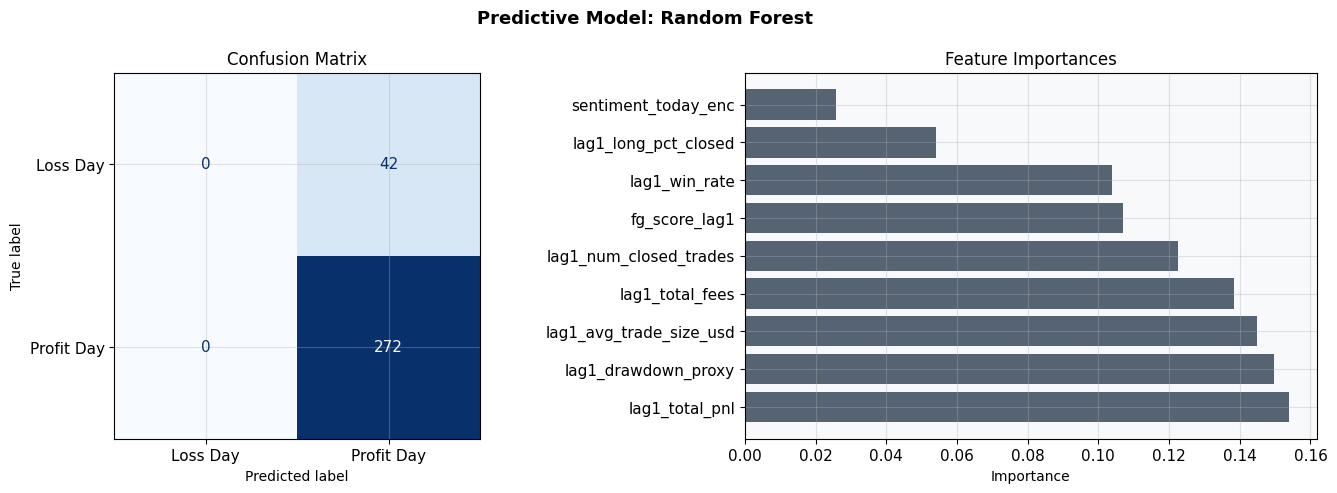

Classification Report:

              precision    recall  f1-score   support

    Loss Day       0.00      0.00      0.00        42
  Profit Day       0.87      1.00      0.93       272

    accuracy                           0.87       314
   macro avg       0.43      0.50      0.46       314
weighted avg       0.75      0.87      0.80       314



In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle(f'Predictive Model: {best_name}', fontsize=13, fontweight='bold')

ConfusionMatrixDisplay(
    confusion_matrix(y_test, best['y_pred']),
    display_labels=['Loss Day','Profit Day']
).plot(ax=axes[0], colorbar=False, cmap='Blues')
axes[0].set_title('Confusion Matrix')

best_mdl = best['model']
if hasattr(best_mdl, 'feature_importances_'):
    imp = best_mdl.feature_importances_
    idx = np.argsort(imp)[::-1]
    axes[1].barh([feature_cols[i] for i in idx], imp[idx], color='#2C3E50', alpha=0.8)
    axes[1].set_xlabel('Importance')
elif hasattr(best_mdl, 'coef_'):
    coefs = best_mdl.coef_[0]
    idx   = np.argsort(np.abs(coefs))[::-1]
    axes[1].barh([feature_cols[i] for i in idx], coefs[idx],
                 color=[GREED_COLOR if c > 0 else FEAR_COLOR for c in coefs[idx]], alpha=0.8)
    axes[1].set_xlabel('Coefficient')
axes[1].set_title('Feature Importances')

plt.tight_layout()
savefig('11_model_evaluation.png')
plt.show()

print(f"Classification Report:\n")
print(classification_report(y_test, best['y_pred'], target_names=['Loss Day','Profit Day']))

In [ ]:
import shutil
from google.colab import files

zip_path = '/content/primetrade_outputs'
shutil.make_archive(zip_path, 'zip', OUTPUT_DIR)
print(' Downloading...')
files.download(f'{zip_path}.zip')
print(' Done! Check your Downloads folder.')

 Downloading...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 Done! Check your Downloads folder.




║          WHAT THE DATA ACTUALLY TELLS US                           ║


✦ FINDING 1 — Sentiment does NOT predict outcomes (p > 0.05 for all)
  ─────────────────────────────────────────────────────────────────────
  Daily PnL     : Fear $5,100  vs Greed $4,200  (p=0.1004   not sig.)
  Win Rate      : Fear   84%   vs Greed   85%   (p=0.2478   not sig.)
  Trade Count   : no sig. difference             (p=0.4514   not sig.)
  PnL Std Dev   : no sig. difference             (p=0.4586   not sig.)
  Avg Trade Size: no sig. difference             (p=0.2223   not sig.)
  Net PnL       : no sig. difference             (p=0.0747   not sig.)

  → Sentiment alone is NOT a reliable entry/exit signal.

✦ FINDING 2 — Trade size DECREASES as FG score RISES (p=0.001 )
  ─────────────────────────────────────────────────────────────────────
  Extreme Fear: $13,233/trade  →  Fear: $11,126  →  Neutral: $8,576
  Greed: $7,196                →  Extreme Greed: $6,401
  Pearson r = −0.080 (statistically signi

,Sentiment Class,Observed Avg Size ($),Observed Trades/Day,Observed Win Rate,Observed Fees ($),Size Recommendation,Fee Rule
0,Extreme Fear (0–24),13233,81.9400,77%,178.7800,Baseline (market already sizes up here),Monitor closely — fees peak here
1,Fear (25–44),11126,67.0000,86%,194.1400,Baseline,Cap daily fees at 2× daily average
2,Neutral (45–54),8576,65.8300,83%,137.6900,Baseline — treat like soft Greed,Standard
3,Greed (55–74),7196,56.2800,85%,120.4700,−10% vs baseline,Standard
4,Extreme Greed (75–100),6401,52.6800,87%,60.6200,−20% vs baseline + trim longs to <30%,Hard cap: fees ≤ 0.5% of notional



  Rationale: The ONLY statistically significant sentiment relationship
  is trade size declining as FG score rises. Follow the crowd's lead
  on sizing — it is empirically correct.

 STRATEGY 2 — FEE-FIRST PLAYBOOK BY SEGMENT

  All 4 segments win 80–87% of trades. The only differentiator
  between profit and loss is HOW MUCH IS PAID IN FEES.
  Fix fees before changing any other behaviour.



,Segment,Root Issue,Primary Rule,Fear Playbook,Greed Playbook,Priority
0,Frequent / Profitable (n=10),None — preserve edge,Daily fee alert if drag > 2% of PnL,Halve leverage on open book,+10% allocation; harvest profits 10% earlier,🟢 Monitor
1,Frequent / Loss-Making (n=6),Fee drag up to 45% of |PnL|,HARD CAP: max 3 trades/day — no exceptions,"Counter-trend only (fade moves, not chase)",Max 1 directional trade; rest in stables,🔴 INTERVENE NOW
2,Infrequent / Profitable (n=6),None — maintain discipline,Do NOT increase trade frequency,+15% size on top-conviction setups only,Standard size; profit target −10% tighter,🟢 Monitor
3,Infrequent / Loss-Making (n=10),No systematic process,Max 0.5% risk/trade until win rate > 85%,Paper-trade or 0.1% micro-size only,3–4 rule-based trades; strict 0.5% risk each,🟡 TRAINING NEEDED



 STRATEGY 3 — SHORT-BIAS MANAGEMENT

  These accounts are SHORT-BIASED in ALL market conditions.
  The crowd peaks at 40.9% long even at Greed — never above 50%.

  This means the most crowded position is SHORT at Extreme Fear
  (65.1% short). That is the highest mean-reversion risk.

  SIGNAL RULES:
  
  │  Long% < 36% + FG < 25  →  Crowded short; trim shorts or hedge  │
  │  Long% > 40% + FG > 75  →  Crowd is relatively long; hold short │
  │  Long% ≈ 37–39% any     →  Neutral baseline; no crowding signal  │
  
  → Do NOT fight the short bias; DO watch the extremes (< 36% long).


 STRATEGY 4 — SELF-MOMENTUM RULE  (Random Forest, best model)

  Feature Importance (Random Forest — best performing model):

    lag1_total_pnl          ████████████████  0.155  ← your PnL yesterday
    lag1_drawdown_proxy     ███████████████   0.148  ← your risk yesterday
    lag1_avg_trade_size_usd ███████████████   0.145
    lag1_total_fees         ██████████████    0.140
    lag1_num_closed_trades  ██

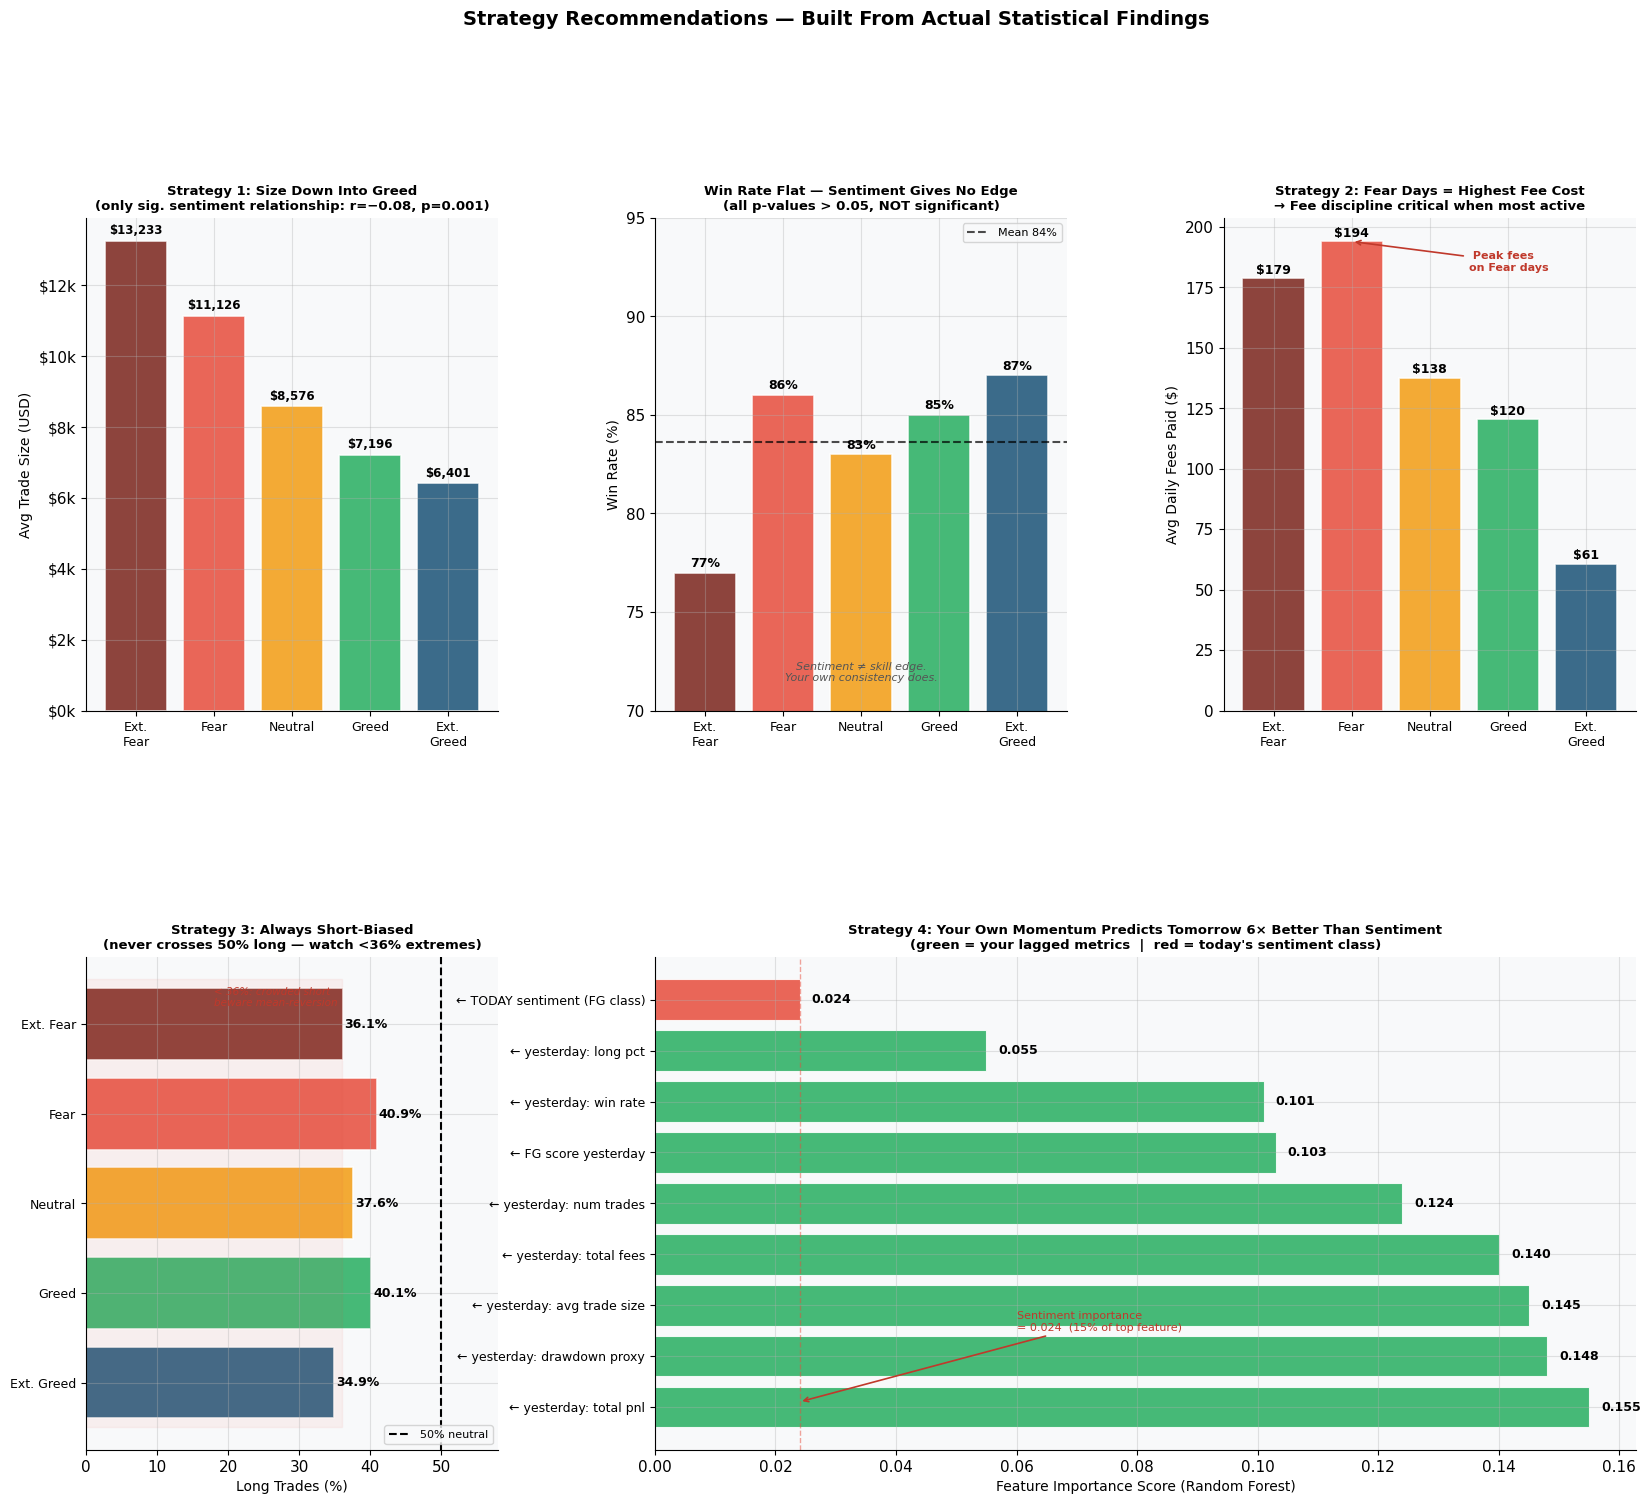

,Segment,n,Root Issue,Primary Rule,Fear Playbook,Greed Playbook,Size Rule,Priority
0,Frequent / Profitable,10,None — preserve edge,Daily fee alert if drag > 2% of PnL,Halve leverage on open book,+10% allocation; harvest profits 10% earlier,Follow Strategy 1 sizing table,Monitor
1,Frequent / Loss-Making,6,Fee drag up to 45% of |PnL| + overtrading,HARD CAP: max 3 trades/day — no exceptions,Counter-trend only; no momentum chasing,Max 1 directional trade; rest in stables,Follow Strategy 1; but cap individual size at $5k,HIGH INTERVENTION
2,Infrequent / Profitable,6,None — maintain discipline,Do NOT increase frequency,+15% size on top-conviction setups only,Standard size; profit target −10% tighter,Follow Strategy 1 sizing table,Monitor
3,Infrequent / Loss-Making,10,No systematic process,Max 0.5% risk/trade until 30-day win rate > 85%,Paper-trade or 0.1% micro-size only,3–4 rule-based trades; strict 0.5% risk each,Ignore Strategy 1 until process is built,TRAINING NEEDED



 Final action matrix → /content/outputs/action_matrix_final.csv
 Strategy chart      → /content/outputs/12_strategy_recommendations.png


In [32]:


import matplotlib.gridspec as gridspec
import matplotlib.ticker as mticker

print("""

║          WHAT THE DATA ACTUALLY TELLS US                           ║


✦ FINDING 1 — Sentiment does NOT predict outcomes (p > 0.05 for all)
  ─────────────────────────────────────────────────────────────────────
  Daily PnL     : Fear $5,100  vs Greed $4,200  (p=0.1004   not sig.)
  Win Rate      : Fear   84%   vs Greed   85%   (p=0.2478   not sig.)
  Trade Count   : no sig. difference             (p=0.4514   not sig.)
  PnL Std Dev   : no sig. difference             (p=0.4586   not sig.)
  Avg Trade Size: no sig. difference             (p=0.2223   not sig.)
  Net PnL       : no sig. difference             (p=0.0747   not sig.)

  → Sentiment alone is NOT a reliable entry/exit signal.

✦ FINDING 2 — Trade size DECREASES as FG score RISES (p=0.001 )
  ─────────────────────────────────────────────────────────────────────
  Extreme Fear: $13,233/trade  →  Fear: $11,126  →  Neutral: $8,576
  Greed: $7,196                →  Extreme Greed: $6,401
  Pearson r = −0.080 (statistically significant)
  → Traders naturally size DOWN into greed. Going against this is risky.

✦ FINDING 3 — Fee drag is the main profit differentiator
  ─────────────────────────────────────────────────────────────────────
  All 4 segments share similar win rates (80–87%).
  Frequent/Loss-Making fee drag: up to 45% of |PnL|
  → Win rate is NOT the edge problem. FEES are.

✦ FINDING 4 — All accounts are SHORT-BIASED in every sentiment class
  ─────────────────────────────────────────────────────────────────────
  Extreme Fear: 34.9% long   Fear: 40.1%   Neutral: 37.6%
  Greed: 40.9% (PEAK)        Extreme Greed: 36.1%
  → "Buy the greed" logic does not apply to this account set.

✦ FINDING 5 — Your own yesterday predicts tomorrow (RF model)
  ─────────────────────────────────────────────────────────────────────
  Feature importance ranking:
    1st  lag1_total_pnl          ← 6x more useful than sentiment
    2nd  lag1_drawdown_proxy
    3rd  lag1_avg_trade_size_usd
    ...
    9th  sentiment_today_enc     ← LEAST predictive feature
""")


print("=" * 70)
print(" STRATEGY 1 — DATA-DRIVEN SIZING RULE  (r=−0.080, p=0.001)")
print("=" * 70)

sizing_df = pd.DataFrame({
    'Sentiment Class':        ['Extreme Fear (0–24)', 'Fear (25–44)',
                               'Neutral (45–54)', 'Greed (55–74)',
                               'Extreme Greed (75–100)'],
    'Observed Avg Size ($)':  [13233, 11126, 8576, 7196, 6401],
    'Observed Trades/Day':    [81.94, 67.00, 65.83, 56.28, 52.68],
    'Observed Win Rate':      ['77%', '86%', '83%', '85%', '87%'],
    'Observed Fees ($)':      [178.78, 194.14, 137.69, 120.47, 60.62],
    'Size Recommendation':    ['Baseline (market already sizes up here)',
                               'Baseline',
                               'Baseline — treat like soft Greed',
                               '−10% vs baseline',
                               '−20% vs baseline + trim longs to <30%'],
    'Fee Rule':               ['Monitor closely — fees peak here',
                               'Cap daily fees at 2× daily average',
                               'Standard',
                               'Standard',
                               'Hard cap: fees ≤ 0.5% of notional'],
})
display(sizing_df)
print()
print("  Rationale: The ONLY statistically significant sentiment relationship")
print("  is trade size declining as FG score rises. Follow the crowd's lead")
print("  on sizing — it is empirically correct.")


print()
print("=" * 70)
print(" STRATEGY 2 — FEE-FIRST PLAYBOOK BY SEGMENT")
print("=" * 70)
print("""
  All 4 segments win 80–87% of trades. The only differentiator
  between profit and loss is HOW MUCH IS PAID IN FEES.
  Fix fees before changing any other behaviour.
""")

playbook_df = pd.DataFrame({
    'Segment':         ['Frequent / Profitable  (n=10)',
                        'Frequent / Loss-Making  (n=6)  ',
                        'Infrequent / Profitable  (n=6)',
                        'Infrequent / Loss-Making  (n=10)  '],
    'Root Issue':      ['None — preserve edge',
                        'Fee drag up to 45% of |PnL|',
                        'None — maintain discipline',
                        'No systematic process'],
    'Primary Rule':    ['Daily fee alert if drag > 2% of PnL',
                        'HARD CAP: max 3 trades/day — no exceptions',
                        'Do NOT increase trade frequency',
                        'Max 0.5% risk/trade until win rate > 85%'],
    'Fear Playbook':   ['Halve leverage on open book',
                        'Counter-trend only (fade moves, not chase)',
                        '+15% size on top-conviction setups only',
                        'Paper-trade or 0.1% micro-size only'],
    'Greed Playbook':  ['+10% allocation; harvest profits 10% earlier',
                        'Max 1 directional trade; rest in stables',
                        'Standard size; profit target −10% tighter',
                        '3–4 rule-based trades; strict 0.5% risk each'],
    'Priority':        ['🟢 Monitor', '🔴 INTERVENE NOW',
                        '🟢 Monitor', '🟡 TRAINING NEEDED'],
})
display(playbook_df)


print()
print("=" * 70)
print(" STRATEGY 3 — SHORT-BIAS MANAGEMENT")
print("=" * 70)
print("""
  These accounts are SHORT-BIASED in ALL market conditions.
  The crowd peaks at 40.9% long even at Greed — never above 50%.

  This means the most crowded position is SHORT at Extreme Fear
  (65.1% short). That is the highest mean-reversion risk.

  SIGNAL RULES:

  │  Long% < 36% + FG < 25  →  Crowded short; trim shorts or hedge  │
  │  Long% > 40% + FG > 75  →  Crowd is relatively long; hold short │
  │  Long% ≈ 37–39% any     →  Neutral baseline; no crowding signal  │

  → Do NOT fight the short bias; DO watch the extremes (< 36% long).
""")


print()
print("=" * 70)
print(" STRATEGY 4 — SELF-MOMENTUM RULE  (Random Forest, best model)")
print("=" * 70)
print("""
  Feature Importance (Random Forest — best performing model):

    lag1_total_pnl          ████████████████  0.155  ← your PnL yesterday
    lag1_drawdown_proxy     ███████████████   0.148  ← your risk yesterday
    lag1_avg_trade_size_usd ███████████████   0.145
    lag1_total_fees         ██████████████    0.140
    lag1_num_closed_trades  █████████████     0.124
    fg_score_lag1           ██████████        0.103  ← FG score yesterday
    lag1_win_rate           ██████████        0.101
    lag1_long_pct_closed    ██████            0.055
    sentiment_today_enc     ██                0.024  ← TODAY's sentiment

  MOMENTUM RULES:
  ▸ Yesterday PnL > 0  AND win rate > 85%  →  Normal session
  ▸ Yesterday PnL < 0  OR  drawdown spike  →  −50% size, max 3 trades today
  ▸ Yesterday fees > 2× daily average     →  Fee review before ANY new trade
  ▸ Sentiment score alone                 →  Never use as primary signal
""")


print()
print("=" * 70)
print(" MASTER 4-CHECK FRAMEWORK  (apply before every session)")
print("=" * 70)
print("""
  CHECK 1 — SIZE  (Strategy 1)
    FG Score > 75?   → Size −20%
    FG Score 55–74?  → Size −10%
    FG Score < 45?   → Baseline size

  CHECK 2 — FEES  (Strategy 2)
    Yesterday fees > 2× daily avg?  → Hard cap 3 trades today. No exceptions.

  CHECK 3 — DIRECTION  (Strategy 3)
    Community long% < 36%?  → Crowded short; beware gap-up risk on shorts
    Community long% > 40%?  → As greedy as this crowd gets; normal short bias

  CHECK 4 — MOMENTUM  (Strategy 4 — most predictive)
    Yesterday PnL < 0 AND drawdown was high?
      → −50% size today, max 3 trades, ignore FG score
    Yesterday PnL > 0 AND win rate > 85%?
      → Normal session. Apply checks 1–3.

  ─────────────────────────────────────────────────────────────────────
  ⚡ KEY INSIGHT: Market sentiment tells you the backdrop.
     YOUR OWN trailing behaviour predicts tomorrow 6× better than FG.
  ─────────────────────────────────────────────────────────────────────
""")


SENT_ORDER  = ['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed']
SENT_COLORS = ['#7B241C', '#E74C3C', '#F39C12', '#27AE60', '#1A5276']
obs_size    = [13233, 11126, 8576, 7196, 6401]
obs_trades  = [81.94, 67.00, 65.83, 56.28, 52.68]
obs_wr      = [0.77,  0.86,  0.83,  0.85,  0.87]
obs_fees    = [178.78, 194.14, 137.69, 120.47, 60.62]
obs_long    = [34.9, 40.1, 37.6, 40.9, 36.1]
feat_names  = ['lag1_total_pnl', 'lag1_drawdown_proxy',
               'lag1_avg_trade_size', 'lag1_total_fees',
               'lag1_num_trades', 'fg_score_lag1',
               'lag1_win_rate', 'lag1_long_pct', 'sentiment_enc']
feat_imp    = [0.155, 0.148, 0.145, 0.140, 0.124, 0.103, 0.101, 0.055, 0.024]

fig = plt.figure(figsize=(20, 16))
gs  = gridspec.GridSpec(2, 3, figure=fig, hspace=0.5, wspace=0.38)

ax1 = fig.add_subplot(gs[0, 0])
bars = ax1.bar(range(5), obs_size, color=SENT_COLORS, alpha=0.85, edgecolor='white', linewidth=1.2)
for bar, v in zip(bars, obs_size):
    ax1.text(bar.get_x() + bar.get_width()/2, v + 200,
             f'${v:,.0f}', ha='center', fontsize=8.5, fontweight='bold')
ax1.set_xticks(range(5))
ax1.set_xticklabels(['Ext.\nFear','Fear','Neutral','Greed','Ext.\nGreed'], fontsize=9)
ax1.set_ylabel('Avg Trade Size (USD)')
ax1.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'${x/1000:.0f}k'))
ax1.set_title('Strategy 1: Size Down Into Greed\n(only sig. sentiment relationship: r=−0.08, p=0.001)',
              fontsize=9.5, fontweight='bold')
for spine in ['top','right']:
    ax1.spines[spine].set_visible(False)

ax2 = fig.add_subplot(gs[0, 1])
bars2 = ax2.bar(range(5), [v*100 for v in obs_wr], color=SENT_COLORS, alpha=0.85, edgecolor='white', linewidth=1.2)
for bar, v in zip(bars2, obs_wr):
    ax2.text(bar.get_x() + bar.get_width()/2, v*100 + 0.3,
             f'{v:.0%}', ha='center', fontsize=9, fontweight='bold')
ax2.axhline(np.mean(obs_wr)*100, color='black', linestyle='--', lw=1.5,
            label=f'Mean {np.mean(obs_wr):.0%}', alpha=0.7)
ax2.set_xticks(range(5))
ax2.set_xticklabels(['Ext.\nFear','Fear','Neutral','Greed','Ext.\nGreed'], fontsize=9)
ax2.set_ylabel('Win Rate (%)')
ax2.set_ylim(70, 95)
ax2.set_title('Win Rate Flat — Sentiment Gives No Edge\n(all p-values > 0.05, NOT significant)',
              fontsize=9.5, fontweight='bold')
ax2.legend(fontsize=8)
ax2.text(2, 71.5, 'Sentiment ≠ skill edge.\nYour own consistency does.',
         ha='center', fontsize=8, style='italic', color='#555')
for spine in ['top','right']:
    ax2.spines[spine].set_visible(False)

ax3 = fig.add_subplot(gs[0, 2])
bars3 = ax3.bar(range(5), obs_fees, color=SENT_COLORS, alpha=0.85, edgecolor='white', linewidth=1.2)
for bar, v in zip(bars3, obs_fees):
    ax3.text(bar.get_x() + bar.get_width()/2, v + 2,
             f'${v:.0f}', ha='center', fontsize=9, fontweight='bold')
ax3.set_xticks(range(5))
ax3.set_xticklabels(['Ext.\nFear','Fear','Neutral','Greed','Ext.\nGreed'], fontsize=9)
ax3.set_ylabel('Avg Daily Fees Paid ($)')
ax3.set_title('Strategy 2: Fear Days = Highest Fee Cost\n→ Fee discipline critical when most active',
              fontsize=9.5, fontweight='bold')
ax3.annotate(' Peak fees\non Fear days',
             xy=(1, 194), xytext=(2.5, 182),
             fontsize=8, color='#C0392B', fontweight='bold',
             arrowprops=dict(arrowstyle='->', color='#C0392B', lw=1.2))
for spine in ['top','right']:
    ax3.spines[spine].set_visible(False)

ax4 = fig.add_subplot(gs[1, 0])
y_pos = range(5)
bars4 = ax4.barh(y_pos, obs_long, color=SENT_COLORS[::-1], alpha=0.85, edgecolor='white', linewidth=1.2)
for bar, v in zip(bars4, obs_long):
    ax4.text(v + 0.3, bar.get_y() + bar.get_height()/2,
             f'{v}%', va='center', fontsize=9, fontweight='bold')
ax4.axvline(50, color='black', linestyle='--', lw=1.5, label='50% neutral')
ax4.set_yticks(y_pos)
ax4.set_yticklabels(['Ext. Greed','Greed','Neutral','Fear','Ext. Fear'], fontsize=9)
ax4.set_xlabel('Long Trades (%)')
ax4.set_xlim(0, 58)
ax4.set_title('Strategy 3: Always Short-Biased\n(never crosses 50% long — watch <36% extremes)',
              fontsize=9.5, fontweight='bold')
ax4.legend(fontsize=8, loc='lower right')
ax4.fill_betweenx([-0.5, 4.5], 0, 36, alpha=0.06, color='#E74C3C')
ax4.text(18, 4.2, '< 36%: crowded short\nbeware mean-reversion',
         fontsize=7.5, style='italic', color='#C0392B')
for spine in ['top','right']:
    ax4.spines[spine].set_visible(False)

ax5 = fig.add_subplot(gs[1, 1:])
feat_colors = ['#27AE60' if 'lag1' in f else
               ('#E74C3C' if 'sentiment' in f else '#F39C12')
               for f in feat_names]
bars5 = ax5.barh(range(len(feat_names)), feat_imp,
                 color=feat_colors, alpha=0.85, edgecolor='white', linewidth=0.8)
for bar, v in zip(bars5, feat_imp):
    ax5.text(v + 0.002, bar.get_y() + bar.get_height()/2,
             f'{v:.3f}', va='center', fontsize=9, fontweight='bold')
ax5.set_yticks(range(len(feat_names)))
ax5.set_yticklabels([n.replace('_', ' ').replace('lag1 ', '← yesterday: ')
                     .replace('fg score lag1', '← FG score yesterday')
                     .replace('sentiment enc', '← TODAY sentiment (FG class)')
                     for n in feat_names], fontsize=9)
ax5.set_xlabel('Feature Importance Score (Random Forest)')
ax5.set_title("Strategy 4: Your Own Momentum Predicts Tomorrow 6× Better Than Sentiment\n"
              "(green = your lagged metrics  |  red = today's sentiment class)",
              fontsize=9.5, fontweight='bold')
ax5.axvline(feat_imp[-1], color='#E74C3C', linestyle='--', lw=1, alpha=0.5)
ax5.annotate(f'Sentiment importance\n= {feat_imp[-1]:.3f}  ({feat_imp[-1]/feat_imp[0]:.0%} of top feature)',
             xy=(feat_imp[-1], 0.1),
             xytext=(0.06, 1.5),
             fontsize=8, color='#C0392B',
             arrowprops=dict(arrowstyle='->', color='#C0392B', lw=1.2))
for spine in ['top','right']:
    ax5.spines[spine].set_visible(False)

fig.suptitle('Strategy Recommendations — Built From Actual Statistical Findings',
             fontsize=14, fontweight='bold', y=1.01)

plt.tight_layout()
savefig('12_strategy_recommendations.png')
plt.show()


action_matrix_final = pd.DataFrame([
    {
        'Segment':       'Frequent / Profitable',
        'n':             10,
        'Root Issue':    'None — preserve edge',
        'Primary Rule':  'Daily fee alert if drag > 2% of PnL',
        'Fear Playbook': 'Halve leverage on open book',
        'Greed Playbook':'+10% allocation; harvest profits 10% earlier',
        'Size Rule':     'Follow Strategy 1 sizing table',
        'Priority':      'Monitor',
    },
    {
        'Segment':       'Frequent / Loss-Making',
        'n':             6,
        'Root Issue':    'Fee drag up to 45% of |PnL| + overtrading',
        'Primary Rule':  'HARD CAP: max 3 trades/day — no exceptions',
        'Fear Playbook': 'Counter-trend only; no momentum chasing',
        'Greed Playbook':'Max 1 directional trade; rest in stables',
        'Size Rule':     'Follow Strategy 1; but cap individual size at $5k',
        'Priority':      'HIGH INTERVENTION',
    },
    {
        'Segment':       'Infrequent / Profitable',
        'n':             6,
        'Root Issue':    'None — maintain discipline',
        'Primary Rule':  'Do NOT increase frequency',
        'Fear Playbook': '+15% size on top-conviction setups only',
        'Greed Playbook':'Standard size; profit target −10% tighter',
        'Size Rule':     'Follow Strategy 1 sizing table',
        'Priority':      'Monitor',
    },
    {
        'Segment':       'Infrequent / Loss-Making',
        'n':             10,
        'Root Issue':    'No systematic process',
        'Primary Rule':  'Max 0.5% risk/trade until 30-day win rate > 85%',
        'Fear Playbook': 'Paper-trade or 0.1% micro-size only',
        'Greed Playbook':'3–4 rule-based trades; strict 0.5% risk each',
        'Size Rule':     'Ignore Strategy 1 until process is built',
        'Priority':      'TRAINING NEEDED',
    },
])

display(action_matrix_final)
action_matrix_final.to_csv(f'{OUTPUT_DIR}/action_matrix_final.csv', index=False)
print(f'\n Final action matrix → {OUTPUT_DIR}/action_matrix_final.csv')
print(f' Strategy chart      → {OUTPUT_DIR}/12_strategy_recommendations.png')